In [1]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp



from environment import Env, validate_against_hint, load_word_lists, construct_word_df, plot_performance_hist


In [2]:
df = construct_word_df(*load_word_lists())

In [3]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [4]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [6]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [7]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)
    
class PolicyHybrid(nn.Module):
    def __init__(self, num_guesses, num_inputs, num_actions):
        super(self.__class__, self).__init__()
        self.functions = torch.nn.ModuleList()
        self.function0 = torch.nn.Parameter(torch.ones((num_actions), dtype=float), requires_grad=True)
        for i in range(1, num_guesses):
            self.functions.append(nn.Linear(num_inputs - num_guesses, num_actions))
        self.x = torch.Tensor([1.0,1.0])

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        if step_idx == 0:
            y = self.x.mul(self.function0)
        else:
            x = state[0:3].to(device)
            y = self.functions[step_idx-1](x)
        return F.softmax(y, dim=0)
    
class PolicyMonteCarlo(nn.Module):
    def __init__(self, num_guesses, num_actions):
        super(PolicyMonteCarlo, self).__init__()
        #self.weights = torch.nn.Parameter(torch.rand((num_guesses, num_actions), dtype=float), requires_grad=True)
        self.weights = torch.nn.Parameter(torch.ones((num_guesses, num_actions), dtype=float), requires_grad=True)
        #self.weights.require_grad = True
        self.x = torch.Tensor([1.0,1.0])
        
    def forward(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        
        y = F.softmax(self.x.mul(self.weights[step_idx]), dim=0)
        #print(f'onehot {onehot}, step_idx {step_idx}')
        #print(self.weights)
        #print(self.weights[step_idx])
        #print(y)
        return y
    
class PolicyAvgReward():
    def __init__(self, num_guesses, num_actions):
        #self.weights = torch.Tensor([[.5,.5],[1,0],[1,0],[1,0],[1,0],[1,0]])
        self.weights = torch.rand((num_guesses, num_actions), dtype=float)
        
        self.reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(num_guesses)]
        self.num_guesses = num_guesses
        self.num_actions = num_actions
        
    def __call__(self, state):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        #if step_idx == 0:
        return F.softmax(self.weights[step_idx], dim=0)
        #else:
        #    return self.weights[step_idx]
    
    def calc_avgs(self):
        for action in range(self.num_actions):
            for step_idx in range(self.num_guesses):
                if self.reward_stats[step_idx][action]['count'] > 0:
                    self.weights[step_idx][action] = self.reward_stats[step_idx][action]['total'] / self.reward_stats[step_idx][action]['count']
        

In [8]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [9]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [10]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    if batch_size <= 0:
        transitions = memory.memory
    else:
        transitions = memory.sample(batch_size)
    print(f'optimize_model_batch {batch_size} {len(transitions)}')
    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

optimizations_run = 0

def optimize_model_single(model, optimizer, state, action, reward):
    global optimizations_run
    optimizations_run += 1
    if isinstance(model, PolicyAvgReward):
        onehot = state[3:]
        step_idx = torch.argmax(onehot, dim=0)
        model.reward_stats[step_idx][action]['count'] += 1
        model.reward_stats[step_idx][action]['total'] += reward
        model.calc_avgs()
        return reward
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [11]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0,
                   run_test=False):
    global optimizations_run
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    reward_stats = [(defaultdict(int),defaultdict(int)) for _ in range(env.num_guesses)]
    transitions_added_to_memory = 0
    optimizations_run = 0
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    elif model.name == 'monte':
        policy_net = PolicyMonteCarlo(env.num_guesses, len(policy_helper.actions)).to(device)
        print('monte weights')
        print(policy_net.weights)
        print(F.softmax(policy_net.weights, dim=1))
    elif model.name == 'avg_reward':
        policy_net = PolicyAvgReward(env.num_guesses, len(policy_helper.actions))
    elif model.name == 'hybrid':
        policy_net = PolicyHybrid(env.num_guesses, n_state_features, len(policy_helper.actions))
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
    
    if model.name == 'avg_reward':
        optimizer = None
    elif training.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    elif training.optimizer == 'sgd':
        optimizer = optim.SGD(policy_net.parameters(), lr=training.lr)
    else:
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)

        #print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for idx,tr in enumerate(episode_memory):
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    transitions_added_to_memory += 1
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    reward_stats[idx][tr[1]]['count'] += 1
                    reward_stats[idx][tr[1]]['total'] += episode_reward
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= max(1,training.batch_size) \
                    and (i_episode + 1) % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                        
                    if model.name == 'monte':
                        print('monte weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'avg_reward':
                        print('avg_reward weights')
                        print(policy_net.weights)
                        print(F.softmax(policy_net.weights, dim=1))
                        for rs in policy_net.reward_stats:
                            if rs[0]['count'] > 0:
                                rs[0]['avg'] = rs[0]['total'] / rs[0]['count']
                            if rs[1]['count'] > 0:
                                rs[1]['avg'] = rs[1]['total'] / rs[1]['count']
                            print(dict(rs[0]), dict(rs[1]))
                    elif model.name == 'hybrid':
                        print('hybrid weights')
                        print(policy_net.function0)
                        print(F.softmax(policy_net.function0, dim=0))
                    print(f'done {optimizations_run} optimizations, {transitions_added_to_memory} transitions added to memory')
                    
                        
                        
                
                #plot_durations()
                break

    print('Training Complete')
    
    if run_test:
        performance_hist = [0] * (1 + env.num_guesses)
        for e in env.foreach_target_word():
            state = starting_state
            done = False
            reward = 0
            guesses = []
            while not done:
                probs = policy_net(state)
                sampler = Categorical(probs)
                action_idx = sampler.sample()
                chosen_word = policy_helper.perform_action(action_idx)
                guesses.append(chosen_word)
                history, reward, done = e.step(chosen_word)
                if not done:
                    state = construct_state_tensor(guesses, history)
            
            num_guesses = len(guesses)
            if num_guesses == 6 and reward == -1:
                num_guesses = 0
            print(f'{e.target} {num_guesses}')    
            performance_hist[num_guesses] += 1
            
        for i,p in enumerate(performance_hist):
            print(f'{i}: {p}')
            
        plot_performance_hist(performance_hist)
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 assay-------
reward -1 done False action 0
------guess 2 0 dandy-------
reward -1 done False action 0
------guess 3 0 fanny-------
reward -1 done False action 0
------guess 4 1 picul-------
reward -1 done False action 1
------guess 5 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 plume======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gibed-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 vozhd-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.0535148

------guess 2 1 gundy-------
reward -1 done False action 1
------guess 3 1 bumph-------
reward -1 done False action 1
------guess 4 0 derby-------
reward 0 done True action 0
episode 19 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3749977317172992  steps 95  memory 90
=========================episode 20 prune======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 prune-------
reward 0 done True action 0
episode 20 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.38430280323571486  steps 98  memory 95
=========================episode 21 stead======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 sweat-------
reward -1 done False action 0
------guess 4 0 steak-------
reward -1 done False action 0
------guess 5 0 stead---

------guess 2 1 lunts-------
reward -1 done False action 1
------guess 3 1 mochy-------
reward -1 done False action 1
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 0 livid-------
reward 0 done True action 0
episode 40 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.605446289628399  steps 187  memory 181
=========================episode 41 nylon======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 nylon-------
reward 0 done True action 0
episode 41 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.611320429098247  steps 190  memory 187
=========================episode 42 drone======================
------guess 0 0 grade-------
reward -1 done False action 0
------guess 1 1 toils-------
reward -1 done False action 1
------guess 2 1 punch-------
reward -1 done False action 1
------guess 3 0 drone-------
reward 0 done True action 0
episode 42 finished.  rew

------guess 3 1 demic-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 annoy-------
reward 0 done True action 0
episode 59 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.7484214469402435  steps 277  memory 271
=========================episode 60 flyer======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 flyer-------
reward 0 done True action 0
episode 60 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7534030360583935  steps 281  memory 277
=========================episode 61 essay======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gibed-------
reward -1 done False action 1
------guess 4 0 essay

------guess 4 1 hedgy-------
reward -1 done False action 1
------guess 5 0 chide-------
reward 0 done True action 0
episode 77 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8395864322248272  steps 367  memory 361
=========================episode 78 speck======================
------guess 0 0 adult-------
reward -1 done False action 0
------guess 1 0 woven-------
reward -1 done False action 0
------guess 2 0 pesky-------
reward -1 done False action 0
------guess 3 0 speck-------
reward 0 done True action 0
episode 78 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8427628336863724  steps 371  memory 367
=========================episode 79 women======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 gooey-------
reward -1 done False action 0
------guess 2 1 linds-------
reward -1 done False action 1
------guess 3 0 coven-------
reward -1 done False action 0
------guess 4 1 bumph-------
reward -1 done False action 1
------guess 5 1 wakfs

------guess 2 1 schul-------
reward -1 done False action 1
------guess 3 0 maxim-------
reward -1 done False action 0
------guess 4 1 byked-------
reward -1 done False action 1
------guess 5 0 pizza-------
reward 0 done True action 0
episode 97 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8982259378937163  steps 458  memory 452
=========================episode 98 segue======================
------guess 0 0 smote-------
reward -1 done False action 0
------guess 1 1 urial-------
reward -1 done False action 1
------guess 2 1 chynd-------
reward -1 done False action 1
------guess 3 0 segue-------
reward 0 done True action 0
episode 98 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9002411993463814  steps 462  memory 458
=========================episode 99 tribe======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 trice-------
reward -1 done False action 0
------guess 2 0 tripe-------
reward -1 done False action 0
------guess 3 1 shuln

------guess 4 0 blurt-------
reward 0 done True action 0
episode 116 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9327944872602503  steps 541  memory 536
=========================episode 117 funny======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bunny-------
reward -1 done False action 0
------guess 3 0 funny-------
reward 0 done True action 0
episode 117 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9341252455735971  steps 545  memory 541
=========================episode 118 treat======================
------guess 0 0 lobby-------
reward -1 done False action 0
------guess 1 0 fetus-------
reward -1 done False action 0
------guess 2 1 cairn-------
reward -1 done False action 1
------guess 3 1 whomp-------
reward -1 done False action 1
------guess 4 0 grate-------
reward -1 done False action 0
------guess 5 1 vodka-------
reward -1 done True action 1
episode 118 finish

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 begad-------
reward -1 done False action 1
------guess 4 0 lucid-------
reward 0 done True action 0
episode 134 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9558428315803071  steps 625  memory 24
=========================episode 135 entry======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 steer-------
reward -1 done False action 0
------guess 2 0 merit-------
reward -1 done False action 0
------guess 3 0 entry-------
reward 0 done True action 0
episode 135 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9567172020980341  steps 629  memory 29
=========================episode 136 quark======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 snarl-------
reward -1 done False action 0
------guess 2 1 cup

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 girth-------
reward -1 done False action 0
------guess 3 0 fritz-------
reward 0 done True action 0
episode 154 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9709866729178029  steps 709  memory 109
=========================episode 155 crony======================
------guess 0 0 stone-------
reward -1 done False action 0
------guess 1 0 frond-------
reward -1 done False action 0
------guess 2 0 wrong-------
reward -1 done False action 0
------guess 3 0 crony-------
reward 0 done True action 0
episode 155 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9715611752858155  steps 713  memory 113
=========================episode 156 power======================
------guess 0 0 sonic-------
reward -1 done False action 0
------guess 1 0 hovel-------
reward -1 done False action 0
------guess 2 1 yurta-------
reward -1 done False action 1
------guess 3 0 mower-------
reward -1 done False action 0
------guess 4 1 p

------guess 2 1 cyano-------
reward -1 done False action 1
------guess 3 0 loyal-------
reward 0 done True action 0
episode 175 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9805517852546146  steps 789  memory 189
=========================episode 176 chard======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 crack-------
reward -1 done False action 0
------guess 3 0 chard-------
reward 0 done True action 0
episode 176 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9809368857083883  steps 793  memory 193
=========================episode 177 bloke======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 endow-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 0 bloke-------
reward 0 done True action 0
episode 177 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.98131436066226

------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 cloak-------
reward 0 done True action 0
episode 195 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9872853448247503  steps 874  memory 273
=========================episode 196 creed======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 cheer-------
reward -1 done False action 0
------guess 2 0 creek-------
reward -1 done False action 0
------guess 3 0 creed-------
reward 0 done True action 0
episode 196 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9875371118656673  steps 878  memory 278
=========================episode 197 sloth======================
------guess 0 0 spray-------
reward -1 done False action 0
------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 0 sloth-------
reward 0 done True action 0
episode 197 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9877226600969315  steps 881  memory 282
=========================episode 

------guess 1 0 udder-------
reward -1 done False action 0
------guess 2 0 ferry-------
reward -1 done False action 0
------guess 3 0 peril-------
reward -1 done False action 0
------guess 4 0 perch-------
reward 0 done True action 0
episode 216 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9918112989856259  steps 962  memory 361
=========================episode 217 tonga======================
------guess 0 0 newer-------
reward -1 done False action 0
------guess 1 1 loast-------
reward -1 done False action 1
------guess 2 0 tonga-------
reward 0 done True action 0
episode 217 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9919332128609004  steps 965  memory 366
=========================episode 218 blast======================
------guess 0 0 aroma-------
reward -1 done False action 0
------guess 1 1 tiles-------
reward -1 done False action 1
------guess 2 0 stalk-------
reward -1 done False action 0
------guess 3 0 blast-------
reward 0 done True action 0
episode 218 finishe

------guess 2 0 shiny-------
reward -1 done False action 0
------guess 3 1 cupid-------
reward -1 done False action 1
------guess 4 0 spiny-------
reward 0 done True action 0
episode 238 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9945383263123592  steps 1043  memory 442
=========================episode 239 sight======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 sight-------
reward 0 done True action 0
episode 239 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9946464746973401  steps 1047  memory 447
=========================episode 240 meaty======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 death-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 meaty-------
reward 0 done True action 0
episode 240 finis

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 local-------
reward 0 done True action 0
episode 256 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.996264972135312  steps 1119  memory 0
=========================episode 257 spoil======================
------guess 0 0 inner-------
reward -1 done False action 0
------guess 1 1 lotas-------
reward -1 done False action 1
------guess 2 0 spoil-------
reward 0 done True action 0
episode 257 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9963205794557457  steps 1122  memory 3
=========================episode 258 gummy======================
------guess 0 0 tonal-------
reward -1 done False action 0
------guess 1 0 husky-------
reward -1 done False action 0
------guess 2 1 cried-------
reward -1 done False action 1
------guess 3 0 fuzzy-------
reward -1 done False action 0
------guess 4 0 guppy-------
reward -1 done False action 0
------guess 5 0 gummy-------
reward 0 done True action 0
episode 258 finished. 

------guess 1 1 stair-------
reward -1 done False action 1
------guess 2 0 drama-------
reward 0 done True action 0
episode 277 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9976065034726508  steps 1208  memory 89
=========================episode 278 ghoul======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 goofy-------
reward -1 done False action 0
------guess 2 1 linds-------
reward -1 done False action 1
------guess 3 0 ghoul-------
reward 0 done True action 0
episode 278 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9976538978793279  steps 1212  memory 92
=========================episode 279 pivot======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 stood-------
reward -1 done False action 0
------guess 2 0 bigot-------
reward -1 done False action 0
------guess 3 0 pilot-------
reward -1 done False action 0
------guess 4 0 pivot-------
reward 0 done True action 0
episode 279 finishe

------guess 2 0 hilly-------
reward -1 done False action 0
------guess 3 0 idyll-------
reward 0 done True action 0
episode 297 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984585010626511  steps 1296  memory 176
=========================episode 298 pupal======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 papal-------
reward -1 done False action 0
------guess 3 0 pupal-------
reward 0 done True action 0
episode 298 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9984890247867068  steps 1300  memory 180
=========================episode 299 bayou======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bayou-------
reward 0 done True action 0
episode 299 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9985115202769406  steps 1303  memory 184
=========================episo

------guess 2 1 lions-------
reward -1 done False action 1
------guess 3 0 slate-------
reward -1 done False action 0
------guess 4 1 munch-------
reward -1 done False action 1
------guess 5 0 stale-------
reward 0 done True action 0
episode 318 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9990121700594687  steps 1385  memory 263
=========================episode 319 spicy======================
------guess 0 0 mason-------
reward -1 done False action 0
------guess 1 1 relit-------
reward -1 done False action 1
------guess 2 0 ficus-------
reward -1 done False action 0
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0 spicy-------
reward 0 done True action 0
episode 319 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9990365596676015  steps 1390  memory 269
=========================episode 320 shack======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 amass-------
reward -1 done False action 0
------guess 2 0

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 relay-------
reward 0 done True action 0
episode 337 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9993574076396444  steps 1471  memory 352
=========================episode 338 young======================
------guess 0 0 miner-------
reward -1 done False action 0
------guess 1 0 chunk-------
reward -1 done False action 0
------guess 2 0 flung-------
reward -1 done False action 0
------guess 3 0 young-------
reward 0 done True action 0
episode 338 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9993701318209024  steps 1475  memory 355
=========================episode 339 duvet======================
------guess 0 0 geeky-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 0 chest-------
reward -1 done False action 0
------guess 3 0 unmet-------
reward -1 done False action 0
------guess 4 0

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 banjo-------
reward -1 done False action 0
------guess 2 0 agony-------
reward 0 done True action 0
episode 358 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995798925306443  steps 1556  memory 437
=========================episode 359 flesh======================
------guess 0 0 chili-------
reward -1 done False action 0
------guess 1 0 hazel-------
reward -1 done False action 0
------guess 2 0 welsh-------
reward -1 done False action 0
------guess 3 0 flesh-------
reward 0 done True action 0
episode 359 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995882112158913  steps 1560  memory 440
=========================episode 360 glean======================
------guess 0 0 haunt-------
reward -1 done False action 0
------guess 1 1 reoil-------
reward -1 done False action 1
------guess 2 1 gymps-------
reward -1 done False action 1
------guess 3 0 glean-------
reward 0 done True action 0
episode 360 finis

------guess 3 1 toils-------
reward -1 done False action 1
------guess 4 0 crane-------
reward -1 done False action 0
------guess 5 0 craze-------
reward 0 done True action 0
episode 377 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9997294354889659  steps 1644  memory 522
=========================episode 378 renew======================
------guess 0 0 biddy-------
reward -1 done False action 0
------guess 1 0 slung-------
reward -1 done False action 0
------guess 2 1 roate-------
reward -1 done False action 1
------guess 3 0 renew-------
reward 0 done True action 0
episode 378 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997347930252404  steps 1648  memory 528
=========================episode 379 chore======================
------guess 0 0 plate-------
reward -1 done False action 0
------guess 1 0 ozone-------
reward -1 done False action 0
------guess 2 1 cursi-------
reward -1 done False action 1
------guess 3 0 chore-------
reward 0 done True action 0
episode 379 finis

------guess 3 1 intro-------
reward -1 done False action 1
------guess 4 0 salvo-------
reward 0 done True action 0
episode 393 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998131118035766  steps 1718  memory 42
=========================episode 394 woken======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 coven-------
reward -1 done False action 0
------guess 3 0 dozen-------
reward -1 done False action 0
------guess 4 0 women-------
reward -1 done False action 0
------guess 5 1 gulph-------
reward -1 done True action 1
episode 394 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.999818635184508  steps 1724  memory 47
=========================episode 395 rival======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 fairy-------
reward -1 done False action 0
------guess 2 1 shuln-------
reward -1 done False action 1
------guess 3 0 v

------guess 3 1 aitus-------
reward -1 done False action 1
------guess 4 1 campy-------
reward -1 done False action 1
------guess 5 0 nosey-------
reward 0 done True action 0
episode 412 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9998831944533201  steps 1812  memory 135
=========================episode 413 glade======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 pedal-------
reward -1 done False action 0
------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 1 vughy-------
reward -1 done False action 1
------guess 4 0 glade-------
reward 0 done True action 0
episode 413 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998860783925432  steps 1817  memory 141
=========================episode 414 shirt======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 third-------
reward -1 done False action 0
------guess 2 0 shirt-------
reward 0 done True action 0
episode 414 finis

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 spilt-------
reward -1 done False action 0
------guess 2 0 hitch-------
reward -1 done False action 0
------guess 3 0 timid-------
reward 0 done True action 0
episode 431 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999243958967153  steps 1899  memory 224
=========================episode 432 write======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 brute-------
reward -1 done False action 0
------guess 2 0 write-------
reward 0 done True action 0
episode 432 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999255214951713  steps 1902  memory 228
=========================episode 433 piper======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 lever-------
reward -1 done False action 0
------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0

------guess 2 0 worry-------
reward 0 done True action 0
episode 450 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999505723216406  steps 1984  memory 310
=========================episode 451 cross======================
------guess 0 0 dairy-------
reward -1 done False action 0
------guess 1 0 broke-------
reward -1 done False action 0
------guess 2 0 prong-------
reward -1 done False action 0
------guess 3 1 cults-------
reward -1 done False action 1
------guess 4 0 cross-------
reward 0 done True action 0
episode 451 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999517926953676  steps 1989  memory 313
=========================episode 452 badge======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 alike-------
reward -1 done False action 0
------guess 2 0 gauge-------
reward -1 done False action 0
------guess 3 0 mange-------
reward -1 done False action 0
------guess 4 0 badge-------
reward 0 done True action 0
episode 452 finis

------guess 0 0 toxic-------
reward -1 done False action 0
------guess 1 0 dally-------
reward -1 done False action 0
------guess 2 0 usual-------
reward -1 done False action 0
------guess 3 1 kreng-------
reward -1 done False action 1
------guess 4 0 learn-------
reward 0 done True action 0
episode 469 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999683255437994  steps 2073  memory 397
=========================episode 470 whack======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 awash-------
reward -1 done False action 0
------guess 2 0 whack-------
reward 0 done True action 0
episode 470 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999687971150164  steps 2076  memory 402
=========================episode 471 clamp======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 snail-------
reward -1 done False action 0
------guess 2 0 chalk-------
reward -1 done False action 0
------guess 3 0

------guess 2 1 nicht-------
reward -1 done False action 1
------guess 3 0 dowry-------
reward 0 done True action 0
episode 491 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999793954781712  steps 2159  memory 484
=========================episode 492 tango======================
------guess 0 0 wimpy-------
reward -1 done False action 0
------guess 1 0 curse-------
reward -1 done False action 0
------guess 2 1 tonal-------
reward -1 done False action 1
------guess 3 0 tango-------
reward 0 done True action 0
episode 492 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999798034750392  steps 2163  memory 488
=========================episode 493 pizza======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 snack-------
reward -1 done False action 0
------guess 2 0 awful-------
reward -1 done False action 0
------guess 3 0 pizza-------
reward 0 done True action 0
episode 493 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999980203393

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 nerdy-------
reward -1 done False action 0
------guess 2 0 verge-------
reward -1 done False action 0
------guess 3 0 perch-------
reward -1 done False action 0
------guess 4 0 peril-------
reward 0 done True action 0
episode 511 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999865965711578  steps 2245  memory 569
optimize_model_batch -1 574
avg_reward weights
tensor([[-3.5571, -3.3720],
        [-2.4569, -2.4449],
        [-1.3598, -1.8129],
        [-0.6173, -1.5667],
        [-0.2857, -1.2667],
        [-0.0548, -1.0000]], dtype=torch.float64)
tensor([[0.4539, 0.5461],
        [0.4970, 0.5030],
        [0.6114, 0.3886],
        [0.7210, 0.2790],
        [0.7273, 0.2727],
        [0.7201, 0.2799]], dtype=torch.float64)
{'count': 219, 'total': -779, 'avg': -3.557077625570776} {'count': 293, 'total': -988, 'avg': -3.372013651877133}
{'count': 267, 'total': -656, 'avg': -2.4569288389513106} {'count': 245, 

gayly 5
musky 3
stain 0
dally 5
bless 4
bravo 5
stung 5
title 4
ruler 6
kiosk 3
blond 4
ennui 4
layer 6
fluid 4
tatty 4
score 6
cutie 4
zebra 6
barge 4
matey 5
bluer 4
aider 4
shook 4
river 6
privy 6
betel 2
frisk 5
bongo 2
begun 4
azure 4
weave 5
genie 5
sound 5
glove 5
braid 4
scope 4
wryly 5
rover 5
assay 4
ocean 2
bloom 4
irate 4
later 4
woken 0
silky 4
wreck 2
dwelt 4
slate 4
smack 4
solid 3
amaze 5
hazel 6
wrist 4
jolly 0
globe 6
flint 3
rouse 4
civil 4
vista 5
relax 5
cover 0
alive 3
beech 6
jetty 0
bliss 5
vocal 0
often 0
dolly 3
eight 4
joker 5
since 5
event 4
ensue 5
shunt 4
diver 5
poser 5
worst 5
sweep 4
alley 5
creed 5
anime 4
leafy 4
bosom 3
dunce 4
stare 3
pudgy 4
waive 5
choir 3
stood 3
spoke 5
outgo 4
delay 4
bilge 0
ideal 4
clasp 4
seize 5
hotly 3
laugh 3
sieve 4
block 4
meant 4
grape 5
noose 4
hardy 5
shied 3
drawl 6
daisy 6
putty 4
strut 4
burnt 4
tulip 5
crick 4
idyll 4
vixen 5
furor 0
geeky 5
cough 4
naive 4
shoal 3
stork 5
bathe 2
aunty 3
check 4
prime 6
brass 5


satyr 4
rarer 3
binge 4
trend 2
nutty 3
leapt 3
amiss 4
split 5
myrrh 6
width 5
sonar 4
tower 3
baron 3
fever 5
waver 0
spark 5
belie 4
sloop 6
expel 5
smote 5
baler 5
above 4
north 4
wafer 4
scant 3
frill 6
awash 6
snack 4
scowl 3
frail 4
drift 0
limbo 3
fence 5
motel 4
ounce 5
wreak 4
revel 4
talon 5
prior 4
knelt 4
cello 4
flake 3
debug 4
anode 3
crime 4
salve 4
scout 4
imbue 0
pinky 5
stave 6
vague 2
chock 0
fight 4
video 5
stone 3
teach 3
cleft 4
frost 4
prawn 4
booty 4
twist 3
apnea 3
stiff 5
plaza 5
ledge 5
tweak 4
board 4
grant 3
medic 4
bacon 5
cable 4
brawl 4
slunk 4
raspy 4
forum 3
drone 6
women 3
mucus 0
boast 4
toddy 5
coven 4
tumor 3
truer 3
wrath 5
stall 5
steam 4
axial 4
purer 0
daily 0
trail 4
niche 5
mealy 3
juice 6
nylon 3
plump 4
merry 4
flail 5
papal 3
wheat 4
berry 3
cower 4
erect 4
brute 0
leggy 4
snipe 4
sinew 4
skier 5
penny 4
jumpy 4
rally 4
umbra 4
scary 3
modem 5
gross 5
avian 4
greed 4
satin 5
tonic 5
parka 4
sniff 4
livid 6
stark 4
trump 4
giddy 5
reuse 5


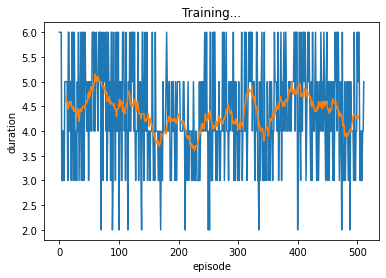

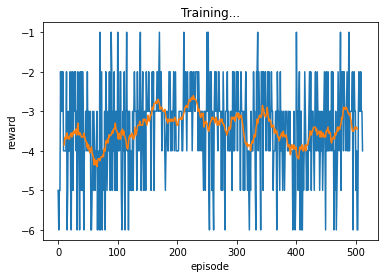

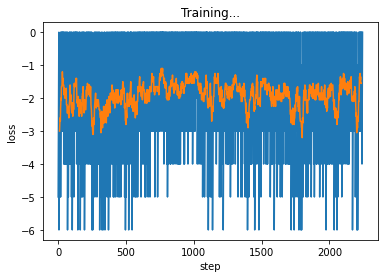

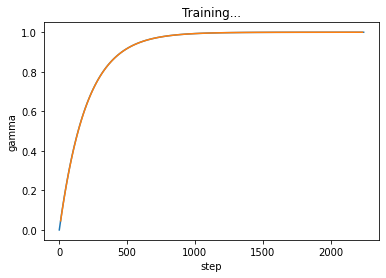

In [12]:
plot_all(*run_experiment(
    model=ModelConfig(name='avg_reward'),
    num_episodes=512,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

monte weights
Parameter containing:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]], dtype=torch.float64, requires_grad=True)
tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 jumbo-------
reward -1 done False action 0
------guess 2 0 tract-------
reward -1 done False action 0
------guess 3 0 gawky-------
reward -1 done False action 0
------guess 4 1 nahal-------
reward -1 done False action 1
------guess 5 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 cabby======================
------guess 0 0 prawn-------
re

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gybed-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 cezve-------
reward -1 done True action 1
episode 19 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.35273533292196535  steps 88  memory 82
=========================episode 20 flume======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 pique-------
reward -1 done False action 0
------guess 2 1 lynch-------
reward -1 done False action 1
------guess 3 1 dumbs-------
reward -1 done False action 1
------guess 4 0 flume-------
reward 0 done True action 0
episode 20 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.36871635449307405  steps 93  memory 88
=========================episode 21 build======================
------guess 0 1 oater-

------guess 3 0 built-------
reward 0 done True action 0
episode 37 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.581048450752361  steps 175  memory 171
=========================episode 38 jaunt======================
------guess 0 0 scene-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 1 humid-------
reward -1 done False action 1
------guess 3 1 pawky-------
reward -1 done False action 1
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 1 vezir-------
reward -1 done True action 1
episode 38 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5934303402594009  steps 181  memory 175
=========================episode 39 vigor======================
------guess 0 0 graft-------
reward -1 done False action 0
------guess 1 1 solei-------
reward -1 done False action 1
------guess 2 0 vigor-------
reward 0 done True action 0
episode 39 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5994833739091812  s

------guess 3 0 posse-------
reward -1 done False action 0
------guess 4 1 thumb-------
reward -1 done False action 1
------guess 5 0 moose-------
reward 0 done True action 0
episode 56 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.7301799436153131  steps 263  memory 257
=========================episode 57 mayor======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 vapor-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 1 duchy-------
reward -1 done False action 1
------guess 4 0 mayor-------
reward 0 done True action 0
episode 57 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7368418245439713  steps 268  memory 263
=========================episode 58 drank======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 crank-------
reward -1 done False action 0
------guess 2 0 drank-------
reward 0 done True action 0
episode 58 finished.  r

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 budge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 furry-------
reward 0 done True action 0
episode 75 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8262260565495548  steps 351  memory 345
=========================episode 76 rigor======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 vigor-------
reward -1 done False action 0
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 rigor-------
reward 0 done True action 0
episode 76 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8305165505005299  steps 356  memory 351
=========================episode 77 soggy======================
------guess 0 0 spore-------
reward -1 done False action 0
------guess 1 1 ictal

------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 0 pasta-------
reward 0 done True action 0
episode 94 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8863918463292362  steps 436  memory 432
=========================episode 95 skimp======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 skimp-------
reward 0 done True action 0
episode 95 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8886414384950874  steps 440  memory 436
=========================episode 96 tibia======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 plant-------
reward -1 done False action 0
------guess 2 0 vista-------
reward -1 done False action 0
------guess 3 0 tibia-------
reward 0 done True action 0
episode 96 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8908464857515359  s

------guess 1 0 mount-------
reward -1 done False action 0
------guess 2 1 clips-------
reward -1 done False action 1
------guess 3 0 lofty-------
reward 0 done True action 0
episode 114 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9268322113040178  steps 524  memory 520
=========================episode 115 often======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 detox-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 often-------
reward 0 done True action 0
episode 115 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9286387304436139  steps 529  memory 524
=========================episode 116 torch======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 turbo-------
reward -1 done False action 0
------guess 3 0 t

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 spank-------
reward -1 done False action 0
------guess 3 0 snack-------
reward 0 done True action 0
episode 131 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.950212931632136  steps 601  memory 13
=========================episode 132 polka======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 vocal-------
reward -1 done False action 0
------guess 3 0 polka-------
reward 0 done True action 0
episode 132 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.951198781637987  steps 605  memory 17
=========================episode 133 admin======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 admin-------
reward 0 done True action 0
episode 133 finished.  

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 bride-------
reward -1 done False action 0
------guess 3 0 fibre-------
reward 0 done True action 0
episode 152 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.966958799624113  steps 683  memory 95
=========================episode 153 droll======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 flour-------
reward -1 done False action 0
------guess 3 0 droll-------
reward 0 done True action 0
episode 153 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.967613059227093  steps 687  memory 99
=========================episode 154 tying======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 visit-------
reward -1 done False action 0
------guess 2 0 tulip-------
reward -1 done False action 0
------guess 3 0 thigh

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 plait-------
reward 0 done True action 0
episode 172 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9780721991057384  steps 765  memory 178
=========================episode 173 cairn======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 spray-------
reward -1 done False action 0
------guess 2 0 umbra-------
reward -1 done False action 0
------guess 3 0 cairn-------
reward 0 done True action 0
episode 173 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9785063986549101  steps 769  memory 181
=========================episode 174 found======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 found-------
reward 0 done True action 0
episode 174 finishe

------guess 0 0 sneak-------
reward -1 done False action 0
------guess 1 1 triol-------
reward -1 done False action 1
------guess 2 0 fifth-------
reward -1 done False action 0
------guess 3 0 digit-------
reward 0 done True action 0
episode 193 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9856642663209885  steps 850  memory 262
=========================episode 194 clean======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 glean-------
reward -1 done False action 0
------guess 3 0 clean-------
reward 0 done True action 0
episode 194 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9859481328669539  steps 854  memory 266
=========================episode 195 midge======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 guide-------
reward -1 done False action 0
------guess 3 0 m

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 after-------
reward 0 done True action 0
episode 214 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9905807517764899  steps 934  memory 347
=========================episode 215 grove======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 prose-------
reward -1 done False action 0
------guess 2 0 broke-------
reward -1 done False action 0
------guess 3 0 erode-------
reward -1 done False action 0
------guess 4 0 crone-------
reward -1 done False action 0
------guess 5 0 froze-------
reward -1 done True action 0
episode 215 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9908591326321099  steps 940  memory 350
=========================episode 216 olive======================
------guess 0 0 prude-------
reward -1 done False action 0
------guess 1 1 salto-------
reward -1 done False action 1
------guess 2 0 globe-------
reward -1 done False action 0
------guess 3 0 

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 theta-------
reward 0 done True action 0
episode 235 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9939336610848368  steps 1022  memory 435
=========================episode 236 ankle======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 shave-------
reward -1 done False action 0
------guess 2 1 unlid-------
reward -1 done False action 1
------guess 3 0 angle-------
reward -1 done False action 0
------guess 4 0 ankle-------
reward 0 done True action 0
episode 236 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9940834395263182  steps 1027  memory 438
=========================episode 237 locus======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 locus-------
reward 0 done True action 0
episode 237 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.994171525635

monte weights
Parameter containing:
tensor([[ 0.2684,  1.7316],
        [ 0.5128,  1.4872],
        [ 1.9704,  0.0296],
        [ 2.4934, -0.4934],
        [ 2.4140, -0.4140],
        [ 1.9897,  0.0103]], dtype=torch.float64, requires_grad=True)
tensor([[0.1880, 0.8120],
        [0.2740, 0.7260],
        [0.8744, 0.1256],
        [0.9520, 0.0480],
        [0.9442, 0.0558],
        [0.8786, 0.1214]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)
{'count': 79, 'total': -292, 'avg': -3.6962025316455698} {'count': 177, 'total': -578, 'avg': -3.2655367231638417}
{'count': 116, 'total': -288, 'avg': -2.4827586206896552} {'count': 138, 'total': -328, 'avg': -2.3768115942028984}
{'count': 178, 'total': -215, 'avg': -1.2078651685393258} {'count': 74, 'total': -149, 'avg': -2.0135135135135136}
{'count': 136, 'total': -64, 'avg': -0.47058823529411764} {'count': 60, 'total': -104, 'avg': -1.7333333333333334}
{'count': 58, 'total': -20, 'avg': -0.3448275862068966} {'count': 38, 'total': -52, 'avg

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 pitch-------
reward 0 done True action 0
episode 272 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9972605551812316  steps 1181  memory 73
=========================episode 273 gauge======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 lapse-------
reward -1 done False action 0
------guess 2 0 maize-------
reward -1 done False action 0
------guess 3 0 badge-------
reward -1 done False action 0
------guess 4 0 gauge-------
reward 0 done True action 0
episode 273 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9973281923148005  steps 1186  memory 77
=========================episode 274 class======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 gland-------
reward -1 done False action 0
------guess 2 0 flaky-------
reward -1 done False action 0
------guess 3 0 p

------guess 3 0 titan-------
reward 0 done True action 0
episode 293 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9982000564937694  steps 1265  memory 157
=========================episode 294 minim======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 unzip-------
reward -1 done False action 0
------guess 3 0 minim-------
reward 0 done True action 0
episode 294 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9982356977631657  steps 1269  memory 161
=========================episode 295 radii======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 radii-------
reward 0 done True action 0
episode 295 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9982619648014261  steps 1272  memory 165
=========================episode 296 chair======================
------guess 0 1 oater---

------guess 3 0 crump-------
reward 0 done True action 0
episode 315 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9988114247998425  steps 1348  memory 240
=========================episode 316 react======================
------guess 0 0 flirt-------
reward -1 done False action 0
------guess 1 1 aeons-------
reward -1 done False action 1
------guess 2 0 react-------
reward 0 done True action 0
episode 316 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9988291203792088  steps 1351  memory 244
=========================episode 317 apnea======================
------guess 0 0 motel-------
reward -1 done False action 0
------guess 1 1 sarin-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 0 annex-------
reward -1 done False action 0
------guess 4 0 apnea-------
reward 0 done True action 0
episode 317 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9988580295000504  steps 1356  memory 247
=========================episo

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 tally-------
reward 0 done True action 0
episode 336 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9992190504446256  steps 1432  memory 325
=========================episode 337 chain======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 affix-------
reward -1 done False action 0
------guess 2 0 quail-------
reward -1 done False action 0
------guess 3 0 chain-------
reward 0 done True action 0
episode 337 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9992345142819025  steps 1436  memory 328
=========================episode 338 graft======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 tract-------
reward -1 done False action 0
------guess 2 0 graft-------
reward 0 done True action 0
episode 338 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9992459108795064  steps 1439  memory 332
=========================episo

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 wager-------
reward -1 done False action 0
------guess 3 0 waver-------
reward -1 done False action 0
------guess 4 0 wafer-------
reward 0 done True action 0
episode 357 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9994868795782053  steps 1516  memory 407
=========================episode 358 dopey======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gooey-------
reward -1 done False action 0
------guess 3 0 dopey-------
reward 0 done True action 0
episode 358 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9994970400433102  steps 1520  memory 412
=========================episode 359 witch======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 hitch-------
reward -1 done False action 0
------guess 2 0

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 crank-------
reward -1 done False action 0
------guess 3 0 prank-------
reward -1 done False action 0
------guess 4 0 frank-------
reward -1 done False action 0
------guess 5 0 drank-------
reward 0 done True action 0
episode 377 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9996611659166366  steps 1599  memory 489
=========================episode 378 crush======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 smirk-------
reward -1 done False action 0
------guess 2 0 crush-------
reward 0 done True action 0
episode 378 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9996662104989342  steps 1602  memory 495
=========================episode 379 sword======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 rough-------
reward -1 done False action 0
------guess 2 0 sworn-------
reward -1 done False action 0
------guess 3 0

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 shall-------
reward 0 done True action 0
episode 395 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997624185390916  steps 1670  memory 46
=========================episode 396 scuba======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 scuba-------
reward 0 done True action 0
episode 396 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997659556662308  steps 1673  memory 49
=========================episode 397 hoard======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 roach-------
reward -1 done False action 0
------guess 3 0 hoard-------
reward 0 done True action 0
episode 397 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997705900545445  steps 1677  memory 52
=========================episode 

------guess 2 1 snuck-------
reward -1 done False action 1
------guess 3 0 hunch-------
reward 0 done True action 0
episode 416 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998438978566632  steps 1754  memory 129
=========================episode 417 corer======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 wooer-------
reward -1 done False action 0
------guess 2 1 lysin-------
reward -1 done False action 1
------guess 3 0 poker-------
reward -1 done False action 0
------guess 4 0 homer-------
reward -1 done False action 0
------guess 5 0 corer-------
reward 0 done True action 0
episode 417 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9998485113722214  steps 1760  memory 133
=========================episode 418 plate======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0

------guess 2 0 flame-------
reward -1 done False action 0
------guess 3 0 place-------
reward 0 done True action 0
episode 437 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998953616040922  steps 1834  memory 209
=========================episode 438 swami======================
------guess 0 0 blind-------
reward -1 done False action 0
------guess 1 1 roate-------
reward -1 done False action 1
------guess 2 1 cushy-------
reward -1 done False action 1
------guess 3 0 swami-------
reward 0 done True action 0
episode 438 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998974335831542  steps 1838  memory 213
=========================episode 439 order======================
------guess 0 0 river-------
reward -1 done False action 0
------guess 1 0 freer-------
reward -1 done False action 0
------guess 2 0 order-------
reward 0 done True action 0
episode 439 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998989605981629  steps 1841  memory 217
=========================episo

------guess 2 0 drunk-------
reward 0 done True action 0
episode 459 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999929858785638  steps 1914  memory 290
=========================episode 460 cluck======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 cluck-------
reward 0 done True action 0
episode 460 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999312476747382  steps 1918  memory 293
=========================episode 461 stove======================
------guess 0 0 arise-------
reward -1 done False action 0
------guess 1 1 clout-------
reward -1 done False action 1
------guess 2 1 nymph-------
reward -1 done False action 1
------guess 3 0 stove-------
reward 0 done True action 0
episode 461 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999326090619917  steps 1922  memory 297
=========================episod

------guess 1 1 solar-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 0 grief-------
reward -1 done False action 0
------guess 4 0 gripe-------
reward -1 done False action 0
------guess 5 0 grime-------
reward 0 done True action 0
episode 479 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999550518070864  steps 2003  memory 376
=========================episode 480 vinyl======================
------guess 0 0 stoop-------
reward -1 done False action 0
------guess 1 1 ariel-------
reward -1 done False action 1
------guess 2 0 vigil-------
reward -1 done False action 0
------guess 3 0 vinyl-------
reward 0 done True action 0
episode 480 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999559418409386  steps 2007  memory 382
=========================episode 481 altar======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 mucky-------
reward -1 done False action 0
------guess 2 0 bully-------
reward -1 done False action 0
------guess 3 0 buddy-------
reward -1 done False action 0
------guess 4 0 bunny-------
reward 0 done True action 0
episode 501 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999970906622878  steps 2090  memory 464
=========================episode 502 girly======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 girly-------
reward 0 done True action 0
episode 502 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999713397668338  steps 2093  memory 469
=========================episode 503 vouch======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 gumbo-------
reward -1 done False action 0
------guess 3 0 

chunk 3
mince 4
slave 4
shame 6
cheek 4
ample 3
flair 3
foyer 0
cargo 4
oxide 3
plant 4
olive 3
inert 4
askew 5
heist 4
shown 4
zesty 4
hasty 4
trash 3
fella 3
larva 4
forgo 4
story 4
hairy 6
train 4
homer 4
badge 2
midst 4
canny 3
fetus 3
butch 4
farce 4
slung 5
tipsy 4
metal 4
yield 3
delve 4
being 4
scour 3
glass 3
gamer 4
scrap 4
money 5
hinge 5
album 3
vouch 4
asset 4
tiara 3
crept 4
bayou 4
atoll 4
manor 5
creak 5
showy 5
phase 3
froth 3
depth 3
gloom 4
flood 5
trait 5
girth 3
piety 4
payer 4
goose 5
float 4
donor 4
atone 3
primo 3
apron 5
blown 5
cacao 4
loser 5
input 5
gloat 3
awful 4
brink 4
smite 3
beady 3
rusty 4
retro 3
droll 4
gawky 4
hutch 4
pinto 4
gaily 4
egret 4
lilac 4
sever 5
field 6
fluff 3
hydro 3
flack 4
agape 5
wench 5
voice 3
stead 0
stalk 4
berth 3
madam 3
night 3
bland 4
liver 4
wedge 3
augur 4
roomy 4
wacky 4
flock 4
angry 4
bobby 4
trite 6
aphid 3
tryst 4
midge 4
power 4
elope 3
cinch 4
motto 4
stomp 5
upset 3
bluff 5
cramp 4
quart 3
coyly 4
youth 5
rhyme 5


cumin 5
stock 3
gravy 4
locus 3
wider 4
breed 6
quite 3
chafe 6
cache 4
blimp 6
deign 4
fiend 4
logic 3
cheap 4
elide 4
rigid 4
false 6
renal 3
pence 4
rowdy 4
shoot 3
blaze 5
envoy 5
posse 5
brief 4
never 4
abort 3
mouse 5
mucky 4
sulky 3
fiery 4
media 4
trunk 3
yeast 4
clear 3
skunk 5
scalp 5
bitty 5
cider 5
koala 3
duvet 3
segue 3
creme 3
super 4
grill 6
after 4
owner 5
ember 5
reach 3
nobly 5
empty 4
speed 4
gipsy 4
recur 4
smock 5
dread 3
merge 4
burst 4
kappa 4
amity 3
shaky 4
hover 6
carol 4
snort 3
synod 3
faint 3
haunt 4
flour 5
chair 3
detox 3
shrew 4
tense 4
plied 3
quark 5
burly 3
novel 3
waxen 4
stoic 3
jerky 4
blitz 4
beefy 3
lyric 4
hussy 4
towel 4
quilt 4
below 4
bingo 3
wispy 5
brash 5
scone 4
toast 3
easel 5
saucy 5
value 4
spice 4
honor 5
route 6
sharp 3
bawdy 4
radii 4
skull 4
phony 4
issue 3
lager 4
swell 5
urine 3
gassy 3
trial 3
flora 3
upper 5
latch 3
wight 5
brick 5
retry 5
holly 0
decal 3
grass 5
shack 5
dogma 3
mover 3
defer 6
sober 4
optic 3
crier 5
vying 4


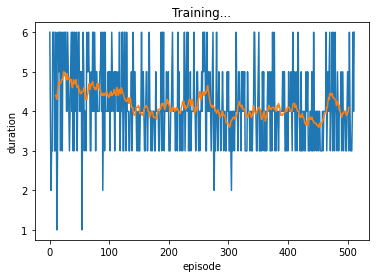

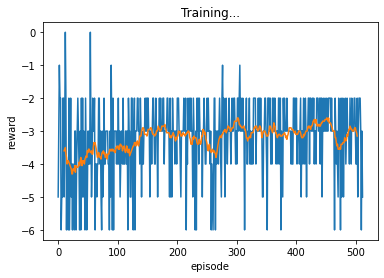

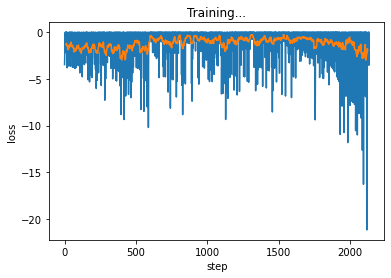

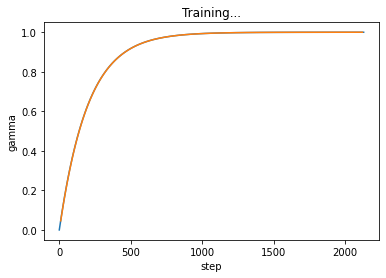

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='monte'),
    num_episodes=512,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 0 spied-------
reward -1 done False action 0
------guess 1 0 jumbo-------
reward -1 done False action 0
------guess 2 1 larnt-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 foyer======================
------guess 0 0 again-------
reward -1 done False action 0
------guess 1 0 there-------
reward -1 done False action 0
------guess 2 1 locus-------
reward -1 done False action 1
------guess 3 0 power-------
reward -1 done False action 0
------guess 4 0 joker-------
reward -1 done False action 0
------guess 5 1 moldy-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.04400251816690004  steps 10  memory 4
=========================episode 2 stool======================
------guess 0 1 orate---

------guess 2 1 synch-------
reward -1 done False action 1
------guess 3 1 bemud-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 weary-------
reward 0 done True action 0
episode 19 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.3655520320517718  steps 92  memory 86
=========================episode 20 lyric======================
------guess 0 0 verve-------
reward -1 done False action 0
------guess 1 1 salto-------
reward -1 done False action 1
------guess 2 1 cumin-------
reward -1 done False action 1
------guess 3 1 hyped-------
reward -1 done False action 1
------guess 4 0 lyric-------
reward 0 done True action 0
episode 20 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.38121660819385916  steps 97  memory 92
=========================episode 21 frame======================
------guess 0 0 befit-------
reward -1 done False action 0
------guess 1 1 soral-------
reward -1 done False action 1
------guess 2 0 frame---

------guess 2 1 triol-------
reward -1 done False action 1
------guess 3 1 gymps-------
reward -1 done False action 1
------guess 4 0 chalk-------
reward 0 done True action 0
episode 38 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5913924013591516  steps 180  memory 175
=========================episode 39 crepe======================
------guess 0 0 crate-------
reward -1 done False action 0
------guess 1 0 creme-------
reward -1 done False action 0
------guess 2 0 crepe-------
reward 0 done True action 0
episode 39 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.597475775966364  steps 183  memory 180
=========================episode 40 acute======================
------guess 0 0 munch-------
reward -1 done False action 0
------guess 1 0 cruel-------
reward -1 done False action 0
------guess 2 1 stoai-------
reward -1 done False action 1
------guess 3 1 podgy-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 0 acute-

------guess 1 0 glade-------
reward -1 done False action 0
------guess 2 1 trons-------
reward -1 done False action 1
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 lever-------
reward -1 done False action 0
------guess 5 1 wakfs-------
reward -1 done True action 1
episode 58 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  steps 270  memory 264
=========================episode 59 stone======================
------guess 0 0 minor-------
reward -1 done False action 0
------guess 1 0 coven-------
reward -1 done False action 0
------guess 2 0 shone-------
reward -1 done False action 0
------guess 3 0 stone-------
reward 0 done True action 0
episode 59 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7446193240119223  steps 274  memory 270
=========================episode 60 dingy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chum

------guess 4 1 updry-------
reward -1 done False action 1
------guess 5 0 spoon-------
reward 0 done True action 0
episode 78 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.836345863197296  steps 363  memory 357
=========================episode 79 title======================
------guess 0 0 beech-------
reward -1 done False action 0
------guess 1 0 spoke-------
reward -1 done False action 0
------guess 2 1 trail-------
reward -1 done False action 1
------guess 3 0 tilde-------
reward -1 done False action 0
------guess 4 1 nummy-------
reward -1 done False action 1
------guess 5 0 title-------
reward 0 done True action 0
episode 79 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8411825738930794  steps 369  memory 363
=========================episode 80 drone======================
------guess 0 0 dryer-------
reward -1 done False action 0
------guess 1 0 drake-------
reward -1 done False action 0
------guess 2 0 drove-------
reward -1 done False action 0
------guess 3 0 drone-

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 delve-------
reward -1 done False action 0
------guess 3 1 chump-------
reward -1 done False action 1
------guess 4 0 quell-------
reward 0 done True action 0
episode 97 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8951264562637131  steps 452  memory 447
=========================episode 98 crate======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 crate-------
reward 0 done True action 0
episode 98 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.896169965459203  steps 454  memory 452
=========================episode 99 local======================
------guess 0 0 melee-------
reward -1 done False action 0
------guess 1 0 flung-------
reward -1 done False action 0
------guess 2 1 ratio-------
reward -1 done False action 1
------guess 3 0 vocal-------
reward -1 done False action 0
------guess 4 1 shady-------
reward -1 done False action 1
------guess 5 0 local-

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 surer-------
reward -1 done False action 0
------guess 2 0 cyber-------
reward -1 done False action 0
------guess 3 0 plier-------
reward -1 done False action 0
------guess 4 1 dwang-------
reward -1 done False action 1
------guess 5 1 humfs-------
reward -1 done True action 1
episode 117 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9331296761534063  steps 542  memory 536
=========================episode 118 ethic======================
------guess 0 0 lefty-------
reward -1 done False action 0
------guess 1 1 noria-------
reward -1 done False action 1
------guess 2 1 chums-------
reward -1 done False action 1
------guess 3 0 ethic-------
reward 0 done True action 0
episode 118 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9344537972819756  steps 546  memory 542
=========================episode 119 lofty======================
------guess 0 0 bonus-------
reward -1 done False action 0
------guess 1 0 

------guess 4 0 murky-------
reward 0 done True action 0
episode 136 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9553990446597255  steps 623  memory 34
=========================episode 137 visit======================
------guess 0 0 cover-------
reward -1 done False action 0
------guess 1 0 vying-------
reward -1 done False action 0
------guess 2 0 visit-------
reward 0 done True action 0
episode 137 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9560630663765926  steps 626  memory 39
=========================episode 138 cumin======================
------guess 0 0 waste-------
reward -1 done False action 0
------guess 1 0 pinky-------
reward -1 done False action 0
------guess 2 0 going-------
reward -1 done False action 0
------guess 3 0 cumin-------
reward 0 done True action 0
episode 138 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9569330759531691  steps 630  memory 42
=========================episode 139 detox======================
------guess 0 0 acorn-------
r

------guess 1 0 stump-------
reward -1 done False action 0
------guess 2 0 bound-------
reward -1 done False action 0
------guess 3 0 boule-------
reward -1 done False action 0
------guess 4 0 bough-------
reward 0 done True action 0
episode 158 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9709866729178029  steps 709  memory 120
=========================episode 159 squat======================
------guess 0 0 wrest-------
reward -1 done False action 0
------guess 1 0 scout-------
reward -1 done False action 0
------guess 2 0 squat-------
reward 0 done True action 0
episode 159 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9714186250837188  steps 712  memory 125
=========================episode 160 cobra======================
------guess 0 0 stole-------
reward -1 done False action 0
------guess 1 0 onion-------
reward -1 done False action 0
------guess 2 0 furor-------
reward -1 done False action 0
------guess 3 0 hydro-------
reward -1 done False action 0
------guess 4 0 c

------guess 1 0 minus-------
reward -1 done False action 0
------guess 2 0 mania-------
reward -1 done False action 0
------guess 3 0 manic-------
reward 0 done True action 0
episode 180 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9815925535892828  steps 800  memory 212
=========================episode 181 vodka======================
------guess 0 0 shoal-------
reward -1 done False action 0
------guess 1 0 abbot-------
reward -1 done False action 0
------guess 2 0 omega-------
reward -1 done False action 0
------guess 3 0 vodka-------
reward 0 done True action 0
episode 181 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9819570454492498  steps 804  memory 216
=========================episode 182 alley======================
------guess 0 0 druid-------
reward -1 done False action 0
------guess 1 0 cagey-------
reward -1 done False action 0
------guess 2 0 alley-------
reward 0 done True action 0
episode 182 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.98222567004634

------guess 3 0 awake-------
reward -1 done False action 0
------guess 4 0 flake-------
reward 0 done True action 0
episode 201 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9879054458749221  steps 884  memory 295
=========================episode 202 lumpy======================
------guess 0 0 child-------
reward -1 done False action 0
------guess 1 0 salsa-------
reward -1 done False action 0
------guess 2 0 elegy-------
reward -1 done False action 0
------guess 3 0 loopy-------
reward -1 done False action 0
------guess 4 0 lumpy-------
reward 0 done True action 0
episode 202 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9882040614802484  steps 889  memory 300
=========================episode 203 pitch======================
------guess 0 0 leant-------
reward -1 done False action 0
------guess 1 0 turbo-------
reward -1 done False action 0
------guess 2 0 stiff-------
reward -1 done False action 0
------guess 3 0 witty-------
reward -1 done False action 0
------guess 4 0 h

------guess 3 0 cluck-------
reward -1 done False action 0
------guess 4 0 clump-------
reward 0 done True action 0
episode 222 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9921716224507742  steps 971  memory 382
=========================episode 223 sense======================
------guess 0 0 eerie-------
reward -1 done False action 0
------guess 1 0 sense-------
reward 0 done True action 0
episode 223 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9922495161088634  steps 973  memory 387
=========================episode 224 olive======================
------guess 0 0 lumen-------
reward -1 done False action 0
------guess 1 0 early-------
reward -1 done False action 0
------guess 2 0 belie-------
reward -1 done False action 0
------guess 3 0 olive-------
reward 0 done True action 0
episode 224 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9924029859724224  steps 977  memory 389
=========================episode 225 leafy======================
------guess 0 0 tenth------

------guess 1 0 watch-------
reward -1 done False action 0
------guess 2 0 happy-------
reward 0 done True action 0
episode 245 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9948563894269696  steps 1055  memory 468
=========================episode 246 reedy======================
------guess 0 0 glory-------
reward -1 done False action 0
------guess 1 0 dirty-------
reward -1 done False action 0
------guess 2 0 ruddy-------
reward -1 done False action 0
------guess 3 0 reedy-------
reward 0 done True action 0
episode 246 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9949582397403091  steps 1059  memory 471
=========================episode 247 voter======================
------guess 0 0 lupus-------
reward -1 done False action 0
------guess 1 0 anode-------
reward -1 done False action 0
------guess 2 0 voter-------
reward 0 done True action 0
episode 247 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9950333017715621  steps 1062  memory 475
=========================episo

------guess 1 0 sulky-------
reward -1 done False action 0
------guess 2 0 slush-------
reward -1 done False action 0
------guess 3 0 slung-------
reward 0 done True action 0
episode 267 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9967038494783457  steps 1144  memory 42
=========================episode 268 staff======================
------guess 0 0 swift-------
reward -1 done False action 0
------guess 1 0 stuff-------
reward -1 done False action 0
------guess 2 0 staff-------
reward 0 done True action 0
episode 268 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9967529227663894  steps 1147  memory 46
=========================episode 269 wryly======================
------guess 0 0 ankle-------
reward -1 done False action 0
------guess 1 0 would-------
reward -1 done False action 0
------guess 2 0 willy-------
reward -1 done False action 0
------guess 3 0 wryly-------
reward 0 done True action 0
episode 269 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99681721920349

------guess 1 0 vapor-------
reward -1 done False action 0
------guess 2 0 debar-------
reward -1 done False action 0
------guess 3 0 sugar-------
reward 0 done True action 0
episode 288 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9978015440369574  steps 1225  memory 123
=========================episode 289 tripe======================
------guess 0 0 truss-------
reward -1 done False action 0
------guess 1 0 trial-------
reward -1 done False action 0
------guess 2 0 trite-------
reward -1 done False action 0
------guess 3 0 trice-------
reward -1 done False action 0
------guess 4 0 tripe-------
reward 0 done True action 0
episode 289 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9978558241080868  steps 1230  memory 127
=========================episode 290 whirl======================
------guess 0 0 weary-------
reward -1 done False action 0
------guess 1 0 whirl-------
reward 0 done True action 0
episode 290 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.997877159014

------guess 3 0 drove-------
reward -1 done False action 0
------guess 4 0 trove-------
reward 0 done True action 0
episode 308 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9985698844016921  steps 1311  memory 208
=========================episode 309 truss======================
------guess 0 0 price-------
reward -1 done False action 0
------guess 1 0 draft-------
reward -1 done False action 0
------guess 2 0 broth-------
reward -1 done False action 0
------guess 3 0 truly-------
reward -1 done False action 0
------guess 4 0 trunk-------
reward -1 done False action 0
------guess 5 0 truss-------
reward 0 done True action 0
episode 309 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9986121507051641  steps 1317  memory 213
=========================episode 310 wreck======================
------guess 0 0 woken-------
reward -1 done False action 0
------guess 1 0 wreck-------
reward 0 done True action 0
episode 310 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.998625960036

------guess 2 0 venue-------
reward -1 done False action 0
------guess 3 0 rerun-------
reward 0 done True action 0
episode 330 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9990650336325834  steps 1396  memory 294
=========================episode 331 poesy======================
------guess 0 0 savvy-------
reward -1 done False action 0
------guess 1 0 tipsy-------
reward -1 done False action 0
------guess 2 0 poesy-------
reward 0 done True action 0
episode 331 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9990789534683306  steps 1399  memory 298
=========================episode 332 decor======================
------guess 0 0 carry-------
reward -1 done False action 0
------guess 1 0 ulcer-------
reward -1 done False action 0
------guess 2 0 decor-------
reward 0 done True action 0
episode 332 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9990926660647225  steps 1402  memory 301
=========================episode 333 slice======================
------guess 0 0 prime---

------guess 1 0 union-------
reward -1 done False action 0
------guess 2 0 unlit-------
reward -1 done False action 0
------guess 3 0 undid-------
reward 0 done True action 0
episode 351 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9993856833216549  steps 1480  memory 378
=========================episode 352 await======================
------guess 0 0 chaos-------
reward -1 done False action 0
------guess 1 0 learn-------
reward -1 done False action 0
------guess 2 0 guava-------
reward -1 done False action 0
------guess 3 0 await-------
reward 0 done True action 0
episode 352 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9993978476068959  steps 1484  memory 382
=========================episode 353 boney======================
------guess 0 0 cress-------
reward -1 done False action 0
------guess 1 0 haute-------
reward -1 done False action 0
------guess 2 0 novel-------
reward -1 done False action 0
------guess 3 0 woken-------
reward -1 done False action 0
------guess 4 0

------guess 3 0 virus-------
reward 0 done True action 0
episode 372 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995983783171967  steps 1565  memory 463
=========================episode 373 girly======================
------guess 0 0 sewer-------
reward -1 done False action 0
------guess 1 0 frail-------
reward -1 done False action 0
------guess 2 0 girly-------
reward 0 done True action 0
episode 373 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999604357685067  steps 1568  memory 467
=========================episode 374 lupus======================
------guess 0 0 doubt-------
reward -1 done False action 0
------guess 1 0 ficus-------
reward -1 done False action 0
------guess 2 0 lupus-------
reward 0 done True action 0
episode 374 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9996102480317473  steps 1571  memory 470
=========================episode 375 purer======================
------guess 0 0 furor-------
reward -1 done False action 0
------guess 1 0 purer----

------guess 1 0 clock-------
reward -1 done False action 0
------guess 2 0 splat-------
reward -1 done False action 0
------guess 3 0 brawl-------
reward -1 done False action 0
------guess 4 0 drawl-------
reward 0 done True action 0
episode 393 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9997400444751889  steps 1652  memory 39
=========================episode 394 serif======================
------guess 0 0 prize-------
reward -1 done False action 0
------guess 1 0 inner-------
reward -1 done False action 0
------guess 2 0 merit-------
reward -1 done False action 0
------guess 3 0 serif-------
reward 0 done True action 0
episode 394 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997451919394614  steps 1656  memory 44
=========================episode 395 cobra======================
------guess 0 0 junta-------
reward -1 done False action 0
------guess 1 0 kappa-------
reward -1 done False action 0
------guess 2 0 circa-------
reward -1 done False action 0
------guess 3 0 c

------guess 1 0 boost-------
reward -1 done False action 0
------guess 2 0 poppy-------
reward -1 done False action 0
------guess 3 0 horny-------
reward -1 done False action 0
------guess 4 0 downy-------
reward 0 done True action 0
episode 414 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999830048932401  steps 1737  memory 124
=========================episode 415 natal======================
------guess 0 0 craft-------
reward -1 done False action 0
------guess 1 0 tango-------
reward -1 done False action 0
------guess 2 0 natal-------
reward 0 done True action 0
episode 415 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998325791741599  steps 1740  memory 129
=========================episode 416 smirk======================
------guess 0 0 pleat-------
reward -1 done False action 0
------guess 1 0 booby-------
reward -1 done False action 0
------guess 2 0 grind-------
reward -1 done False action 0
------guess 3 0 smirk-------
reward 0 done True action 0
episode 416 finish

------guess 4 0 grate-------
reward 0 done True action 0
episode 436 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998937801972535  steps 1831  memory 218
=========================episode 437 spank======================
------guess 0 0 admit-------
reward -1 done False action 0
------guess 1 0 rarer-------
reward -1 done False action 0
------guess 2 0 chaos-------
reward -1 done False action 0
------guess 3 0 spank-------
reward 0 done True action 0
episode 437 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999895883490269  steps 1835  memory 223
=========================episode 438 pizza======================
------guess 0 0 hilly-------
reward -1 done False action 0
------guess 1 0 digit-------
reward -1 done False action 0
------guess 2 0 river-------
reward -1 done False action 0
------guess 3 0 pizza-------
reward 0 done True action 0
episode 438 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998979451352924  steps 1839  memory 227
=========================episod

------guess 3 0 pasty-------
reward 0 done True action 0
episode 458 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.999929858785638  steps 1914  memory 302
=========================episode 459 pulse======================
------guess 0 0 wedge-------
reward -1 done False action 0
------guess 1 0 froze-------
reward -1 done False action 0
------guess 2 0 slave-------
reward -1 done False action 0
------guess 3 0 pulse-------
reward 0 done True action 0
episode 459 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999312476747382  steps 1918  memory 306
=========================episode 460 depot======================
------guess 0 0 humor-------
reward -1 done False action 0
------guess 1 0 detox-------
reward -1 done False action 0
------guess 2 0 depot-------
reward 0 done True action 0
episode 460 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999322712635091  steps 1921  memory 310
=========================episode 461 tabby======================
------guess 0 0 brand----

------guess 1 0 blink-------
reward -1 done False action 0
------guess 2 0 skunk-------
reward -1 done False action 0
------guess 3 0 chunk-------
reward 0 done True action 0
episode 479 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999546000702375  steps 2001  memory 389
=========================episode 480 delay======================
------guess 0 0 chunk-------
reward -1 done False action 0
------guess 1 0 tamer-------
reward -1 done False action 0
------guess 2 0 abode-------
reward -1 done False action 0
------guess 3 0 ideal-------
reward -1 done False action 0
------guess 4 0 delay-------
reward 0 done True action 0
episode 480 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999557209984973  steps 2006  memory 393
=========================episode 481 retry======================
------guess 0 0 share-------
reward -1 done False action 0
------guess 1 0 leery-------
reward -1 done False action 0
------guess 2 0 decry-------
reward -1 done False action 0
------guess 3 0

------guess 1 0 sweat-------
reward -1 done False action 0
------guess 2 0 splat-------
reward -1 done False action 0
------guess 3 0 squat-------
reward 0 done True action 0
episode 499 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999700205976366  steps 2084  memory 472
=========================episode 500 trump======================
------guess 0 0 blurt-------
reward -1 done False action 0
------guess 1 0 truss-------
reward -1 done False action 0
------guess 2 0 truce-------
reward -1 done False action 0
------guess 3 0 truth-------
reward -1 done False action 0
------guess 4 0 trump-------
reward 0 done True action 0
episode 500 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999707607917183  steps 2089  memory 476
=========================episode 501 abate======================
------guess 0 0 spare-------
reward -1 done False action 0
------guess 1 0 flame-------
reward -1 done False action 0
------guess 2 0 agate-------
reward -1 done False action 0
------guess 3 0

egret 5
lilac 3
sever 4
field 3
fluff 4
hydro 3
flack 4
agape 4
wench 4
voice 4
stead 4
stalk 3
berth 5
madam 3
night 5
bland 5
liver 6
wedge 4
augur 4
roomy 5
wacky 4
flock 3
angry 4
bobby 5
trite 4
aphid 4
tryst 4
midge 4
power 6
elope 4
cinch 5
motto 4
stomp 3
upset 5
bluff 5
cramp 4
quart 5
coyly 6
youth 3
rhyme 4
buggy 3
alien 3
smear 4
unfit 4
patty 5
cling 3
glean 3
label 5
hunky 5
khaki 5
poker 5
gruel 3
twice 5
twang 3
shrug 4
treat 5
unlit 5
waste 3
merit 3
woven 3
octal 3
needy 3
clown 3
widow 4
irony 4
ruder 4
gauze 5
chief 5
onset 3
prize 3
fungi 3
charm 3
gully 6
inter 4
whoop 3
taunt 6
leery 3
class 5
theme 3
lofty 2
tibia 3
booze 4
alpha 3
thyme 4
eclat 4
doubt 4
parer 4
chute 4
stick 4
trice 5
alike 6
sooth 5
recap 3
saint 4
liege 4
glory 3
grate 3
admit 3
brisk 4
soggy 3
usurp 4
scald 4
scorn 3
leave 5
twine 5
sting 4
bough 3
marsh 3
sloth 6
dandy 4
vigor 5
howdy 4
enjoy 5
valid 4
ionic 3
equal 2
unset 4
floor 4
catch 5
spade 5
stein 3
exist 3
quirk 4
denim 3
grove 4


quilt 4
below 2
bingo 4
wispy 4
brash 5
scone 3
toast 5
easel 4
saucy 2
value 4
spice 3
honor 5
route 3
sharp 4
bawdy 3
radii 3
skull 4
phony 5
issue 3
lager 5
swell 4
urine 3
gassy 5
trial 5
flora 4
upper 4
latch 5
wight 0
brick 3
retry 4
holly 3
decal 3
grass 3
shack 2
dogma 4
mover 6
defer 4
sober 5
optic 4
crier 3
vying 4
nomad 6
flute 4
hippo 3
shark 4
drier 5
obese 3
bugle 3
tawny 3
chalk 6
feast 4
ruddy 3
pedal 5
scarf 5
cruel 3
bleat 4
tidal 3
slush 5
semen 5
windy 5
dusty 6
sally 6
igloo 4
nerdy 2
jewel 5
shone 4
whale 4
hymen 4
abuse 3
fugue 5
elbow 3
crumb 4
pansy 3
welsh 4
syrup 5
terse 4
suave 6
gamut 4
swung 4
drake 3
freed 5
afire 6
shirt 4
grout 4
oddly 4
tithe 5
plaid 6
dummy 4
broom 6
blind 5
torch 6
enemy 4
again 3
tying 3
pesky 4
alter 4
gazer 5
noble 4
ethos 4
bride 4
extol 4
decor 4
hobby 4
beast 0
idiom 4
utter 5
these 4
sixth 5
alarm 4
erase 4
elegy 4
spunk 5
piper 6
scaly 5
scold 6
hefty 4
chick 4
sooty 3
canal 3
whiny 4
slash 3
quake 3
joint 4
swept 4
prude 5


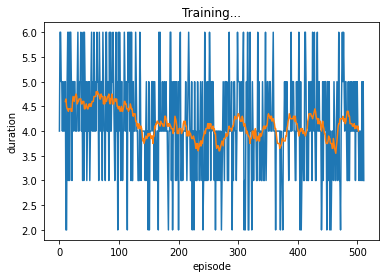

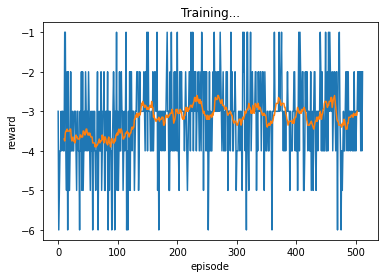

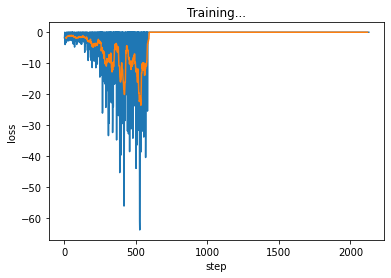

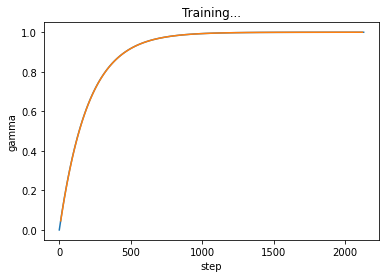

In [14]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=512,
    training=TrainConfig(optimizer='rmsprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.009950166250831893  steps 3  memory 0
=========================episode 1 truce======================
------guess 0 0 vowel-------
reward -1 done False action 0
------guess 1 1 tiars-------
reward -1 done False action 1
------guess 2 0 trend-------
reward -1 done False action 0
------guess 3 0 truce-------
reward 0 done True action 0
episode 1 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.029554466451491845  steps 7  memory 3
=========================episode 2 puree======================
------guess 0 0 wheat-------
reward -1 done False action 0
------guess 1 1 loris-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 1 guimp----

------guess 2 1 incus-------
reward -1 done False action 1
------guess 3 0 tonga-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3494909052766835  steps 87  memory 83
=========================episode 21 cabal======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 gibed-------
reward -1 done False action 1
------guess 4 0 cabal-------
reward 0 done True action 0
episode 21 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.3655520320517718  steps 92  memory 87
=========================episode 22 under======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 under-------
reward 0 done True action 0
episode 22 finished.  rewar

------guess 5 1 kivas-------
reward -1 done True action 1
episode 39 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5789484473726788  steps 174  memory 168
=========================episode 40 opium======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 opium-------
reward 0 done True action 0
episode 40 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5852170883184187  steps 177  memory 174
=========================episode 41 gaunt======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 begad-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 0 gaunt-------
reward 0 done True action 0
episode 41 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.597475775966364  s

------guess 3 1 synch-------
reward -1 done False action 1
------guess 4 0 equip-------
reward 0 done True action 0
episode 60 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 261
=========================episode 61 mayor======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 foray-------
reward -1 done False action 0
------guess 3 0 mayor-------
reward 0 done True action 0
episode 61 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7394602921400244  steps 270  memory 266
=========================episode 62 rumba======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 radar-------
reward -1 done False action 0
------guess 3 0 rumba-------
reward 0 done True action 0
episode 62 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7446193240119223  s

------guess 3 0 recut-------
reward 0 done True action 0
episode 80 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8279551361769495  steps 353  memory 349
=========================episode 81 bleat======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 tweak-------
reward -1 done False action 0
------guess 2 0 pleat-------
reward -1 done False action 0
------guess 3 1 incus-------
reward -1 done False action 1
------guess 4 1 hedgy-------
reward -1 done False action 1
------guess 5 0 bleat-------
reward 0 done True action 0
episode 81 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8330398303329594  steps 359  memory 353
=========================episode 82 sword======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 hydro-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 1 panim-------
reward -1 done False action 1
------guess 4 0 sword

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 chaff-------
reward -1 done False action 0
------guess 3 1 dumps-------
reward -1 done False action 1
------guess 4 0 guava-------
reward 0 done True action 0
episode 99 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8919325813651707  steps 446  memory 441
=========================episode 100 eclat======================
------guess 0 0 spike-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 0 eclat-------
reward 0 done True action 0
episode 100 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8940724596264547  steps 450  memory 446
=========================episode 101 trump======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 thrum-------
reward -1 done False action 0
------guess 3 1 ca

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 flank-------
reward -1 done False action 0
------guess 2 1 scudi-------
reward -1 done False action 1
------guess 3 1 humpy-------
reward -1 done False action 1
------guess 4 0 clang-------
reward 0 done True action 0
episode 118 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9310931716053374  steps 536  memory 531
=========================episode 119 prowl======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 crook-------
reward -1 done False action 0
------guess 2 0 broil-------
reward -1 done False action 0
------guess 3 0 growl-------
reward -1 done False action 0
------guess 4 1 dunsh-------
reward -1 done False action 1
------guess 5 0 prowl-------
reward 0 done True action 0
episode 119 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9331296761534063  steps 542  memory 536
=========================episode 120 kneel======================
------guess 0 1 o

------guess 3 0 eerie-------
reward -1 done False action 0
------guess 4 0 beret-------
reward 0 done True action 0
episode 138 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9558428315803071  steps 625  memory 39
=========================episode 139 tooth======================
------guess 0 0 udder-------
reward -1 done False action 0
------guess 1 0 sonic-------
reward -1 done False action 0
------guess 2 0 folly-------
reward -1 done False action 0
------guess 3 0 booth-------
reward -1 done False action 0
------guess 4 0 tooth-------
reward 0 done True action 0
episode 139 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9569330759531691  steps 630  memory 44
=========================episode 140 think======================
------guess 0 0 folly-------
reward -1 done False action 0
------guess 1 0 abuse-------
reward -1 done False action 0
------guess 2 0 chirp-------
reward -1 done False action 0
------guess 3 0 think-------
reward 0 done True action 0
episode 140 finished.

------guess 1 0 haunt-------
reward 0 done True action 0
episode 159 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9702521970459025  steps 704  memory 121
=========================episode 160 verge======================
------guess 0 0 realm-------
reward -1 done False action 0
------guess 1 0 nerdy-------
reward -1 done False action 0
------guess 2 0 serve-------
reward -1 done False action 0
------guess 3 0 verge-------
reward 0 done True action 0
episode 160 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9708412430106028  steps 708  memory 123
=========================episode 161 slack======================
------guess 0 0 snowy-------
reward -1 done False action 0
------guess 1 0 serum-------
reward -1 done False action 0
------guess 2 0 salad-------
reward -1 done False action 0
------guess 3 0 stall-------
reward -1 done False action 0
------guess 4 0 slack-------
reward 0 done True action 0
episode 161 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.97156117528581

------guess 5 0 round-------
reward -1 done True action 0
episode 182 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9812206985053156  steps 796  memory 209
=========================episode 183 pique======================
------guess 0 0 child-------
reward -1 done False action 0
------guess 1 0 infer-------
reward -1 done False action 0
------guess 2 0 biome-------
reward -1 done False action 0
------guess 3 0 pixie-------
reward -1 done False action 0
------guess 4 0 pique-------
reward 0 done True action 0
episode 183 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9816843611112658  steps 801  memory 215
=========================episode 184 sauce======================
------guess 0 0 spoke-------
reward -1 done False action 0
------guess 1 0 style-------
reward -1 done False action 0
------guess 2 0 siege-------
reward -1 done False action 0
------guess 3 0 scare-------
reward -1 done False action 0
------guess 4 0 sauce-------
reward 0 done True action 0
episode 184 finish

------guess 1 0 dizzy-------
reward -1 done False action 0
------guess 2 0 optic-------
reward -1 done False action 0
------guess 3 0 choir-------
reward -1 done False action 0
------guess 4 0 curio-------
reward 0 done True action 0
episode 203 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9875992707795566  steps 879  memory 293
=========================episode 204 kappa======================
------guess 0 0 briar-------
reward -1 done False action 0
------guess 1 0 scald-------
reward -1 done False action 0
------guess 2 0 eaten-------
reward -1 done False action 0
------guess 3 0 mamma-------
reward -1 done False action 0
------guess 4 0 kappa-------
reward 0 done True action 0
episode 204 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9879054458749221  steps 884  memory 298
=========================episode 205 homer======================
------guess 0 0 track-------
reward -1 done False action 0
------guess 1 0 surer-------
reward -1 done False action 0
------guess 2 0 l

------guess 2 0 curvy-------
reward -1 done False action 0
------guess 3 0 curry-------
reward -1 done False action 0
------guess 4 0 curly-------
reward 0 done True action 0
episode 222 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9920134787340446  steps 967  memory 381
=========================episode 223 relay======================
------guess 0 0 beast-------
reward -1 done False action 0
------guess 1 0 vegan-------
reward -1 done False action 0
------guess 2 0 repay-------
reward -1 done False action 0
------guess 3 0 relay-------
reward 0 done True action 0
episode 223 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9921716224507742  steps 971  memory 386
=========================episode 224 glean======================
------guess 0 0 knave-------
reward -1 done False action 0
------guess 1 0 ocean-------
reward -1 done False action 0
------guess 2 0 glean-------
reward 0 done True action 0
episode 224 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.99228817180853

------guess 2 0 shard-------
reward -1 done False action 0
------guess 3 0 stark-------
reward -1 done False action 0
------guess 4 0 snarl-------
reward 0 done True action 0
episode 245 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9950084060930898  steps 1061  memory 475
=========================episode 246 steep======================
------guess 0 0 foggy-------
reward -1 done False action 0
------guess 1 0 harem-------
reward -1 done False action 0
------guess 2 0 tenet-------
reward -1 done False action 0
------guess 3 0 sweet-------
reward -1 done False action 0
------guess 4 0 steed-------
reward -1 done False action 0
------guess 5 0 steep-------
reward 0 done True action 0
episode 246 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.995155929987751  steps 1067  memory 480
=========================episode 247 coyly======================
------guess 0 0 eight-------
reward -1 done False action 0
------guess 1 0 pound-------
reward -1 done False action 0
------guess 2 0 

------guess 3 0 canon-------
reward -1 done False action 0
------guess 4 0 salon-------
reward 0 done True action 0
episode 265 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9966873274551001  steps 1143  memory 34
=========================episode 266 scalp======================
------guess 0 0 twixt-------
reward -1 done False action 0
------guess 1 0 glade-------
reward -1 done False action 0
------guess 2 0 koala-------
reward -1 done False action 0
------guess 3 0 scalp-------
reward 0 done True action 0
episode 266 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9967529227663894  steps 1147  memory 39
=========================episode 267 chuck======================
------guess 0 0 hello-------
reward -1 done False action 0
------guess 1 0 birch-------
reward -1 done False action 0
------guess 2 0 whack-------
reward -1 done False action 0
------guess 3 0 chuck-------
reward 0 done True action 0
episode 267 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99681721920349

------guess 2 0 preen-------
reward -1 done False action 0
------guess 3 0 repel-------
reward 0 done True action 0
episode 286 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9979191940825505  steps 1236  memory 128
=========================episode 287 canal======================
------guess 0 0 dying-------
reward -1 done False action 0
------guess 1 0 junta-------
reward -1 done False action 0
------guess 2 0 canal-------
reward 0 done True action 0
episode 287 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9979501732467237  steps 1239  memory 132
=========================episode 288 slurp======================
------guess 0 0 sonar-------
reward -1 done False action 0
------guess 1 0 shrew-------
reward -1 done False action 0
------guess 2 0 spurt-------
reward -1 done False action 0
------guess 3 0 slurp-------
reward 0 done True action 0
episode 288 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9979907625359299  steps 1243  memory 135
=========================episo

------guess 3 0 jewel-------
reward 0 done True action 0
episode 308 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.998646416826345  steps 1322  memory 214
=========================episode 309 along======================
------guess 0 0 bread-------
reward -1 done False action 0
------guess 1 0 axiom-------
reward -1 done False action 0
------guess 2 0 aloft-------
reward -1 done False action 0
------guess 3 0 along-------
reward 0 done True action 0
episode 309 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.998673219568973  steps 1326  memory 218
=========================episode 310 limbo======================
------guess 0 0 gnash-------
reward -1 done False action 0
------guess 1 0 weedy-------
reward -1 done False action 0
------guess 2 0 flock-------
reward -1 done False action 0
------guess 3 0 moult-------
reward -1 done False action 0
------guess 4 0 limbo-------
reward 0 done True action 0
episode 310 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.99870597789453

------guess 1 0 nicer-------
reward -1 done False action 0
------guess 2 0 cinch-------
reward -1 done False action 0
------guess 3 0 pinch-------
reward -1 done False action 0
------guess 4 0 finch-------
reward -1 done False action 0
------guess 5 0 winch-------
reward 0 done True action 0
episode 330 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9991282431372008  steps 1410  memory 300
=========================episode 331 bossy======================
------guess 0 0 tramp-------
reward -1 done False action 0
------guess 1 0 liege-------
reward -1 done False action 0
------guess 2 0 woozy-------
reward -1 done False action 0
------guess 3 0 hobby-------
reward -1 done False action 0
------guess 4 0 bossy-------
reward 0 done True action 0
episode 331 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9991497668908332  steps 1415  memory 306
=========================episode 332 helix======================
------guess 0 0 affix-------
reward -1 done False action 0
------guess 1 0

------guess 2 0 whiny-------
reward -1 done False action 0
------guess 3 0 thing-------
reward -1 done False action 0
------guess 4 0 shine-------
reward 0 done True action 0
episode 351 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9994214583399453  steps 1492  memory 383
=========================episode 352 piney======================
------guess 0 0 flung-------
reward -1 done False action 0
------guess 1 0 cairn-------
reward -1 done False action 0
------guess 2 0 kinky-------
reward -1 done False action 0
------guess 3 0 piney-------
reward 0 done True action 0
episode 352 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9994329142323617  steps 1496  memory 388
=========================episode 353 gully======================
------guess 0 0 alone-------
reward -1 done False action 0
------guess 1 0 dryly-------
reward -1 done False action 0
------guess 2 0 hilly-------
reward -1 done False action 0
------guess 3 0 sully-------
reward -1 done False action 0
------guess 4 0

=========================episode 372 circa======================
------guess 0 0 envoy-------
reward -1 done False action 0
------guess 1 0 sprig-------
reward -1 done False action 0
------guess 2 0 birth-------
reward -1 done False action 0
------guess 3 0 circa-------
reward 0 done True action 0
episode 372 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9996273980998108  steps 1580  memory 472
=========================episode 373 smack======================
------guess 0 0 breed-------
reward -1 done False action 0
------guess 1 0 foamy-------
reward -1 done False action 0
------guess 2 0 small-------
reward -1 done False action 0
------guess 3 0 smash-------
reward -1 done False action 0
------guess 4 0 smack-------
reward 0 done True action 0
episode 373 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999636597673505  steps 1585  memory 476
=========================episode 374 shave======================
------guess 0 0 idler-------
reward -1 done False action 0
------gues

------guess 2 0 rebut-------
reward -1 done False action 0
------guess 3 0 tuber-------
reward 0 done True action 0
episode 394 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9997588279551214  steps 1667  memory 38
=========================episode 395 rabid======================
------guess 0 0 rusty-------
reward -1 done False action 0
------guess 1 0 rebar-------
reward -1 done False action 0
------guess 2 0 rabid-------
reward 0 done True action 0
episode 395 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997624185390916  steps 1670  memory 42
=========================episode 396 salon======================
------guess 0 0 kneel-------
reward -1 done False action 0
------guess 1 0 slant-------
reward -1 done False action 0
------guess 2 0 salon-------
reward 0 done True action 0
episode 396 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997659556662308  steps 1673  memory 45
=========================episode 397 sheik======================
------guess 0 0 privy------

------guess 1 0 honor-------
reward -1 done False action 0
------guess 2 0 cough-------
reward -1 done False action 0
------guess 3 0 vouch-------
reward 0 done True action 0
episode 417 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998477520323147  steps 1759  memory 130
=========================episode 418 elude======================
------guess 0 0 rebut-------
reward -1 done False action 0
------guess 1 0 ounce-------
reward -1 done False action 0
------guess 2 0 usage-------
reward -1 done False action 0
------guess 3 0 plume-------
reward -1 done False action 0
------guess 4 0 elude-------
reward 0 done True action 0
episode 418 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998515110480304  steps 1764  memory 134
=========================episode 419 gloat======================
------guess 0 0 beast-------
reward -1 done False action 0
------guess 1 0 paint-------
reward -1 done False action 0
------guess 2 0 adult-------
reward -1 done False action 0
------guess 3 0

------guess 1 0 coral-------
reward -1 done False action 0
------guess 2 0 silky-------
reward -1 done False action 0
------guess 3 0 plunk-------
reward -1 done False action 0
------guess 4 0 flunk-------
reward 0 done True action 0
episode 437 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9998994645342819  steps 1842  memory 212
=========================episode 438 foray======================
------guess 0 0 lemon-------
reward -1 done False action 0
------guess 1 0 radio-------
reward -1 done False action 0
------guess 2 0 ovary-------
reward -1 done False action 0
------guess 3 0 foray-------
reward 0 done True action 0
episode 438 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999014552698828  steps 1846  memory 217
=========================episode 439 carry======================
------guess 0 0 nasty-------
reward -1 done False action 0
------guess 1 0 gaudy-------
reward -1 done False action 0
------guess 2 0 balmy-------
reward -1 done False action 0
------guess 3 0

------guess 3 0 silly-------
reward -1 done False action 0
------guess 4 0 sixty-------
reward -1 done False action 0
------guess 5 0 sissy-------
reward 0 done True action 0
episode 459 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9999355744329657  steps 1931  memory 300
=========================episode 460 sally======================
------guess 0 0 lemon-------
reward -1 done False action 0
------guess 1 0 trial-------
reward -1 done False action 0
------guess 2 0 scalp-------
reward -1 done False action 0
------guess 3 0 sadly-------
reward -1 done False action 0
------guess 4 0 sally-------
reward 0 done True action 0
episode 460 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999371651058834  steps 1936  memory 306
=========================episode 461 jetty======================
------guess 0 0 rigid-------
reward -1 done False action 0
------guess 1 0 below-------
reward -1 done False action 0
------guess 2 0 fetus-------
reward -1 done False action 0
------guess 3 0

------guess 1 0 build-------
reward -1 done False action 0
------guess 2 0 mulch-------
reward -1 done False action 0
------guess 3 0 gulch-------
reward 0 done True action 0
episode 480 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999589204447747  steps 2021  memory 392
=========================episode 481 larva======================
------guess 0 0 pixel-------
reward -1 done False action 0
------guess 1 0 dolly-------
reward -1 done False action 0
------guess 2 0 stalk-------
reward -1 done False action 0
------guess 3 0 lunar-------
reward -1 done False action 0
------guess 4 0 larva-------
reward 0 done True action 0
episode 481 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999959934702607  steps 2026  memory 396
=========================episode 482 study======================
------guess 0 0 paddy-------
reward -1 done False action 0
------guess 1 0 moody-------
reward -1 done False action 0
------guess 2 0 study-------
reward 0 done True action 0
episode 482 finish

=========================episode 501 aphid======================
------guess 0 0 olden-------
reward -1 done False action 0
------guess 1 0 third-------
reward -1 done False action 0
------guess 2 0 humid-------
reward -1 done False action 0
------guess 3 0 aphid-------
reward 0 done True action 0
episode 501 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999739371596631  steps 2112  memory 483
=========================episode 502 scoff======================
------guess 0 0 ruddy-------
reward -1 done False action 0
------guess 1 0 pitch-------
reward -1 done False action 0
------guess 2 0 clove-------
reward -1 done False action 0
------guess 3 0 scoff-------
reward 0 done True action 0
episode 502 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999744532384791  steps 2116  memory 487
=========================episode 503 patio======================
------guess 0 0 expel-------
reward -1 done False action 0
------guess 1 0 champ-------
reward -1 done False action 0
------gue

chute 4
stick 4
trice 5
alike 3
sooth 3
recap 3
saint 2
liege 4
glory 3
grate 6
admit 5
brisk 5
soggy 5
usurp 2
scald 3
scorn 3
leave 4
twine 4
sting 4
bough 4
marsh 3
sloth 4
dandy 5
vigor 3
howdy 6
enjoy 4
valid 5
ionic 4
equal 3
unset 3
floor 5
catch 5
spade 6
stein 3
exist 4
quirk 4
denim 6
grove 6
spiel 4
mummy 6
fault 4
foggy 5
flout 5
carry 6
sneak 4
libel 4
waltz 5
aptly 5
piney 3
inept 4
aloud 3
photo 5
dream 3
stale 2
vomit 4
ombre 4
fanny 4
unite 5
snarl 5
baker 5
there 4
glyph 5
pooch 4
hippy 5
spell 6
folly 5
louse 6
gulch 4
vault 5
godly 4
threw 3
fleet 4
grave 0
inane 5
shock 6
crave 0
spite 4
valve 5
skimp 2
claim 4
rainy 3
musty 5
pique 4
daddy 5
quasi 3
arise 5
aging 4
valet 4
opium 5
avert 4
stuck 4
recut 3
mulch 4
genre 4
plume 4
rifle 3
count 4
incur 4
total 3
wrest 4
mocha 4
deter 3
study 3
lover 4
safer 3
rivet 5
funny 4
smoke 4
mound 6
undue 4
sedan 5
pagan 3
swine 4
guile 6
gusty 3
equip 3
tough 4
canoe 5
chaos 4
covet 3
human 3
udder 4
lunch 3
blast 6
stray 3


dummy 6
broom 4
blind 3
torch 4
enemy 4
again 4
tying 4
pesky 3
alter 3
gazer 5
noble 5
ethos 3
bride 4
extol 4
decor 4
hobby 0
beast 5
idiom 5
utter 5
these 4
sixth 6
alarm 5
erase 5
elegy 4
spunk 4
piper 6
scaly 3
scold 3
hefty 0
chick 3
sooty 3
canal 5
whiny 4
slash 4
quake 3
joint 5
swept 4
prude 5
heavy 5
wield 2
femme 5
lasso 4
maize 3
shale 4
screw 4
spree 3
smoky 3
whiff 4
scent 5
glade 5
spent 6
prism 4
stoke 4
riper 4
orbit 3
cocoa 3
guilt 3
humus 5
shush 3
table 4
smirk 4
wrong 3
noisy 3
alert 3
shiny 4
elate 6
resin 2
whole 4
hunch 6
pixel 5
polar 3
hotel 3
sword 3
cleat 4
mango 5
rumba 4
puffy 4
filly 0
billy 4
leash 5
clout 4
dance 2
ovate 5
facet 3
chili 4
paint 3
liner 5
curio 3
salty 3
audio 4
snake 5
fable 5
cloak 4
navel 5
spurt 4
pesto 3
balmy 3
flash 6
unwed 3
early 5
churn 4
weedy 5
stump 2
lease 5
witty 5
wimpy 4
spoof 5
saner 3
blend 5
salsa 4
thick 6
warty 3
manic 4
blare 4
squib 4
spoon 4
probe 3
crepe 5
knack 4
force 6
debut 5
order 4
haste 3
teeth 5
agent 4


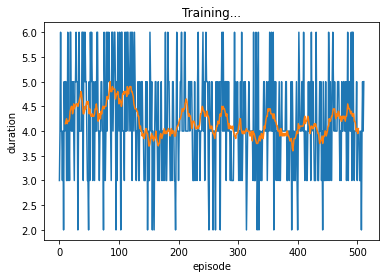

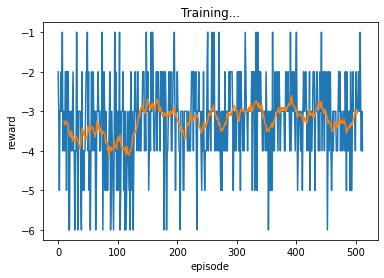

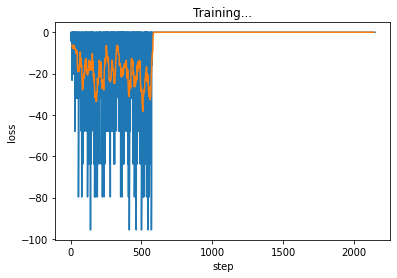

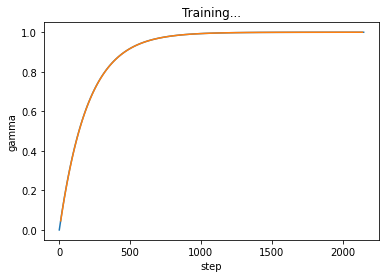

In [15]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=512,
    training=TrainConfig(optimizer='rmsprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 dandy-------
reward -1 done False action 0
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.024690087971667385  steps 6  memory 0
=========================episode 1 beefy======================
------guess 0 0 vowel-------
reward -1 done False action 0
------guess 1 1 tiars-------
reward -1 done False action 1
------guess 2 1 cundy-------
reward -1 done False action 1
------guess 3 0 geeky-------
reward -1 done False action 0
------guess 4 1 bumph-------
reward -1 done False action 1
------guess 5 1 hafiz-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.0535148

------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 ardor-------
reward -1 done False action 0
------guess 4 1 befog-------
reward -1 done False action 1
------guess 5 0 favor-------
reward 0 done True action 0
episode 19 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.3718648948103592  steps 94  memory 88
=========================episode 20 valor======================
------guess 0 0 could-------
reward -1 done False action 0
------guess 1 0 valor-------
reward 0 done True action 0
episode 20 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.3781149435349799  steps 96  memory 94
=========================episode 21 noble======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 clone-------
reward -1 done False action 0
------guess 3 0 noble-------
reward 0 done True action 0
episode 21 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.39042909270369075  step

------guess 1 0 abode-------
reward -1 done False action 0
------guess 2 0 ahead-------
reward 0 done True action 0
episode 40 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 170
=========================episode 41 usual======================
------guess 0 0 psalm-------
reward -1 done False action 0
------guess 1 0 usual-------
reward 0 done True action 0
episode 41 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.581048450752361  steps 175  memory 173
=========================episode 42 graft======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 draft-------
reward -1 done False action 0
------guess 4 1 bewig-------
reward -1 done False action 1
------guess 5 1 kieve-------
reward -1 done True action 1
episode 42 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.5934303402594009  s

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 femme-------
reward -1 done False action 0
------guess 3 0 deuce-------
reward -1 done False action 0
------guess 4 0 hedge-------
reward -1 done False action 0
------guess 5 0 wedge-------
reward 0 done True action 0
episode 60 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 256
=========================episode 61 urine======================
------guess 0 0 snare-------
reward -1 done False action 0
------guess 1 1 lotic-------
reward -1 done False action 1
------guess 2 1 dumpy-------
reward -1 done False action 1
------guess 3 0 urine-------
reward 0 done True action 0
episode 61 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 262
=========================episode 62 stave======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 stage

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 stack-------
reward 0 done True action 0
episode 79 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.828813213515059  steps 354  memory 351
=========================episode 80 tried======================
------guess 0 0 reset-------
reward -1 done False action 0
------guess 1 1 aloin-------
reward -1 done False action 1
------guess 2 0 timer-------
reward -1 done False action 0
------guess 3 0 tried-------
reward 0 done True action 0
episode 80 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8322029389998141  steps 358  memory 354
=========================episode 81 block======================
------guess 0 0 unfit-------
reward -1 done False action 0
------guess 1 1 realo-------
reward -1 done False action 1
------guess 2 0 gloss-------
reward -1 done False action 0
------guess 3 0 block-------
reward 0 done True action 0
episode 81 finished.  re

reward -1 done False action 1
------guess 1 0 angle-------
reward -1 done False action 0
------guess 2 1 scudi-------
reward -1 done False action 1
------guess 3 0 fable-------
reward 0 done True action 0
episode 99 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8880832513826711  steps 439  memory 435
=========================episode 100 trunk======================
------guess 0 0 court-------
reward -1 done False action 0
------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 0 trunk-------
reward 0 done True action 0
episode 100 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8897494746955148  steps 442  memory 439
=========================episode 101 needy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 libel-------
reward -1 done False action 0
------guess 2 0 weedy-------
reward -1 done False action 0
------guess 3 0 needy-------
reward 0 done True action 0
episode 101 finished.  reward -3  eps [0.9, 0.05,

------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 clone-------
reward 0 done True action 0
episode 119 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9257264217856661  steps 521  memory 517
=========================episode 120 saucy======================
------guess 0 0 basil-------
reward -1 done False action 0
------guess 1 1 tenor-------
reward -1 done False action 1
------guess 2 1 duchy-------
reward -1 done False action 1
------guess 3 1 gramp-------
reward -1 done False action 1
------guess 4 0 saucy-------
reward 0 done True action 0
episode 120 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9275602429657486  steps 526  memory 521
=========================episode 121 wreak======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 arena-------
reward -1 done False action 0
------guess 2 0 dread-------
reward -1 done False action 0
------guess 3 0 cream-------
reward -1 done False action 0
------guess 4 1 h

------guess 1 0 stash-------
reward -1 done False action 0
------guess 2 0 giant-------
reward -1 done False action 0
------guess 3 0 plate-------
reward -1 done False action 0
------guess 4 0 ovate-------
reward -1 done False action 0
------guess 5 0 abate-------
reward 0 done True action 0
episode 140 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9509541645129833  steps 604  memory 44
=========================episode 141 flaky======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 shank-------
reward -1 done False action 0
------guess 2 0 flaky-------
reward 0 done True action 0
episode 141 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9516843618739322  steps 607  memory 50
=========================episode 142 kebab======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 sedan-------
reward -1 done False action 0
------guess 2 0 fecal-------
reward -1 done False action 0
------guess 3 0 keb

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 natal-------
reward -1 done False action 0
------guess 2 0 hatch-------
reward -1 done False action 0
------guess 3 0 datum-------
reward -1 done False action 0
------guess 4 0 patsy-------
reward 0 done True action 0
episode 160 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9677745897680832  steps 688  memory 129
=========================episode 161 swami======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 avail-------
reward -1 done False action 0
------guess 2 0 khaki-------
reward -1 done False action 0
------guess 3 0 swami-------
reward 0 done True action 0
episode 161 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9684126956439092  steps 692  memory 134
=========================episode 162 truss======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 brunt-------
reward -1 done False action 0
------guess 2 0 t

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 voter-------
reward -1 done False action 0
------guess 2 0 tower-------
reward 0 done True action 0
episode 183 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9789320004769586  steps 773  memory 216
=========================episode 184 plumb======================
------guess 0 0 gland-------
reward -1 done False action 0
------guess 1 0 flume-------
reward -1 done False action 0
------guess 2 0 plumb-------
reward 0 done True action 0
episode 184 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9792456621263003  steps 776  memory 219
=========================episode 185 showy======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 flock-------
reward -1 done False action 0
------guess 2 0 spoon-------
reward -1 done False action 0
------guess 3 0 showy-------
reward 0 done True action 0
episode 185 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.97965662555083

------guess 2 0 email-------
reward -1 done False action 0
------guess 3 0 mealy-------
reward 0 done True action 0
episode 203 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9860879512810624  steps 856  memory 298
=========================episode 204 flume======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 midge-------
reward -1 done False action 0
------guess 2 0 plume-------
reward -1 done False action 0
------guess 3 1 synch-------
reward -1 done False action 1
------guess 4 0 flume-------
reward 0 done True action 0
episode 204 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9864314409877991  steps 861  memory 302
=========================episode 205 crone======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 crone-------
reward 0 done True action 0
episode 205 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9865664504057546  steps 863  memory 307
=========================episode 

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 cress-------
reward -1 done False action 0
------guess 2 0 giver-------
reward -1 done False action 0
------guess 3 0 nerdy-------
reward -1 done False action 0
------guess 4 0 berry-------
reward 0 done True action 0
episode 225 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9908133138437554  steps 939  memory 380
=========================episode 226 crate======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 grate-------
reward -1 done False action 0
------guess 2 0 irate-------
reward -1 done False action 0
------guess 3 0 crate-------
reward 0 done True action 0
episode 226 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9909952224175634  steps 943  memory 385
=========================episode 227 carve======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 farce-------
reward -1 done False action 0
------guess 2 0 c

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 conch-------
reward -1 done False action 0
------guess 2 0 goody-------
reward -1 done False action 0
------guess 3 0 polyp-------
reward 0 done True action 0
episode 246 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.994053782643528  steps 1026  memory 468
=========================episode 247 habit======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 taint-------
reward -1 done False action 0
------guess 2 0 habit-------
reward 0 done True action 0
episode 247 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9941423102866643  steps 1029  memory 472
=========================episode 248 ditto======================
------guess 0 0 cheek-------
reward -1 done False action 0
------guess 1 0 stray-------
reward -1 done False action 0
------guess 2 0 blunt-------
reward -1 done False action 0
------guess 3 0 motif-------
reward -1 done False action 0
------guess 4 0 

ionic 4
equal 5
unset 4
floor 3
catch 3
spade 5
stein 4
exist 5
quirk 3
denim 4
grove 4
spiel 4
mummy 5
fault 4
foggy 0
flout 4
carry 6
sneak 3
libel 4
waltz 3
aptly 4
piney 3
inept 3
aloud 5
photo 4
dream 3
stale 3
vomit 4
ombre 3
fanny 5
unite 2
snarl 3
baker 0
there 4
glyph 3
pooch 3
hippy 5
spell 4
folly 5
louse 3
gulch 3
vault 5
godly 5
threw 3
fleet 5
grave 4
inane 3
shock 4
crave 4
spite 3
valve 3
skimp 3
claim 3
rainy 4
musty 4
pique 3
daddy 6
quasi 4
arise 4
aging 4
valet 3
opium 4
avert 3
stuck 4
recut 3
mulch 4
genre 4
plume 4
rifle 4
count 3
incur 4
total 4
wrest 3
mocha 3
deter 3
study 6
lover 3
safer 5
rivet 3
funny 6
smoke 5
mound 4
undue 3
sedan 4
pagan 4
swine 4
guile 4
gusty 5
equip 4
tough 5
canoe 3
chaos 3
covet 5
human 4
udder 5
lunch 3
blast 3
stray 4
manga 3
melee 4
lefty 4
quick 3
paste 6
given 3
octet 5
risen 4
groan 4
leaky 5
grind 3
carve 4
loose 4
sadly 3
spilt 4
apple 5
slack 5
honey 5
final 4
sheen 4
eerie 4
minty 3
slick 5
derby 5
wharf 4
spelt 5
coach 4


scold 4
hefty 4
chick 4
sooty 5
canal 4
whiny 3
slash 3
quake 6
joint 6
swept 5
prude 4
heavy 4
wield 4
femme 5
lasso 4
maize 3
shale 4
screw 5
spree 4
smoky 3
whiff 4
scent 4
glade 4
spent 4
prism 3
stoke 2
riper 6
orbit 3
cocoa 5
guilt 4
humus 4
shush 4
table 3
smirk 3
wrong 6
noisy 3
alert 6
shiny 3
elate 5
resin 3
whole 5
hunch 0
pixel 5
polar 4
hotel 3
sword 5
cleat 5
mango 4
rumba 4
puffy 4
filly 5
billy 5
leash 3
clout 3
dance 4
ovate 3
facet 2
chili 4
paint 6
liner 5
curio 3
salty 4
audio 3
snake 5
fable 5
cloak 3
navel 5
spurt 5
pesto 3
balmy 5
flash 5
unwed 3
early 3
churn 3
weedy 4
stump 3
lease 3
witty 4
wimpy 4
spoof 3
saner 4
blend 5
salsa 3
thick 4
warty 3
manic 6
blare 5
squib 4
spoon 3
probe 5
crepe 5
knack 3
force 4
debut 4
order 5
haste 6
teeth 2
agent 3
widen 5
icily 4
slice 5
ingot 4
clash 4
juror 3
blood 5
abode 4
throw 4
unity 4
pivot 4
slept 4
troop 4
spare 4
sewer 4
parse 4
morph 5
cacti 5
tacky 4
spool 5
demon 4
moody 6
annex 3
begin 4
fuzzy 5
patch 3
water 0


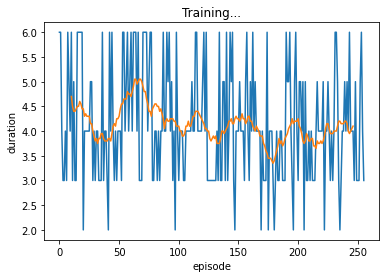

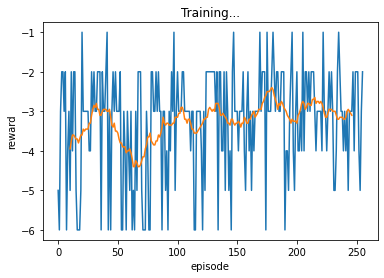

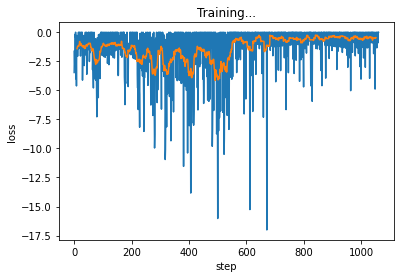

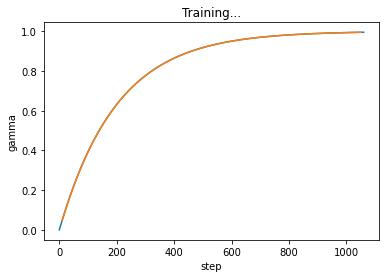

In [16]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=256,
    training=TrainConfig(optimizer='sgd', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

In [12]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=384,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 beefy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 mince-------
reward -1 done False action 0
------guess 2 0 shell-------
reward -1 done False action 0
------guess 3 1 pudgy-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 1 favel-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.04400251816690004  steps 10  memory 4
=========================episode 2 excel======================
------guess 0 0 natal---

------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 chalk-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3494909052766835  steps 87  memory 83
=========================episode 21 noose======================
------guess 0 0 three-------
reward -1 done False action 0
------guess 1 1 aloin-------
reward -1 done False action 1
------guess 2 0 ozone-------
reward -1 done False action 0
------guess 3 1 cuspy-------
reward -1 done False action 1
------guess 4 1 midgy-------
reward -1 done False action 1
------guess 5 1 bawks-------
reward -1 done True action 1
episode 21 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.36871635449307405  steps 93  memory 87
=========================episode 22 weird======================
------guess 0 0 bosom-------
reward -1 done False action 0
------guess 1 0 grand-------
reward -1 done False action 0
------guess 2 0 weird-------
reward 0 done True action 0
episode 22 finished.  rew

------guess 2 0 badge-------
reward -1 done False action 0
------guess 3 0 mamma-------
reward -1 done False action 0
------guess 4 1 purty-------
reward -1 done False action 1
------guess 5 0 kayak-------
reward 0 done True action 0
episode 41 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.581048450752361  steps 175  memory 169
=========================episode 42 swash======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 swash-------
reward 0 done True action 0
episode 42 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5893442472476544  steps 179  memory 175
=========================episode 43 relay======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 relay-------
reward 0 done True action 0
episode 43 finished.  re

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 spore-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 prove-------
reward -1 done False action 0
------guess 4 0 probe-------
reward 0 done True action 0
episode 62 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 257
=========================episode 63 picky======================
------guess 0 0 turbo-------
reward -1 done False action 0
------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 1 chynd-------
reward -1 done False action 1
------guess 3 0 picky-------
reward 0 done True action 0
episode 63 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7341970409110734  steps 266  memory 262
=========================episode 64 faint======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 paint

------guess 1 1 irone-------
reward -1 done False action 1
------guess 2 0 grime-------
reward -1 done False action 0
------guess 3 0 drive-------
reward -1 done False action 0
------guess 4 1 yucch-------
reward -1 done False action 1
------guess 5 0 pride-------
reward 0 done True action 0
episode 82 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.828813213515059  steps 354  memory 348
=========================episode 83 spurt======================
------guess 0 0 clock-------
reward -1 done False action 0
------guess 1 1 terai-------
reward -1 done False action 1
------guess 2 0 grunt-------
reward -1 done False action 0
------guess 3 0 spurt-------
reward 0 done True action 0
episode 83 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8322029389998141  steps 358  memory 354
=========================episode 84 liken======================
------guess 0 0 chase-------
reward -1 done False action 0
------guess 1 1 lirot-------
reward -1 done False action 1
------guess 2 0 libel-

------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 0 focal-------
reward -1 done False action 0
------guess 4 0 local-------
reward -1 done False action 0
------guess 5 1 hyped-------
reward -1 done True action 1
episode 102 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.8891968416376661  steps 441  memory 435
=========================episode 103 phony======================
------guess 0 0 nomad-------
reward -1 done False action 0
------guess 1 1 relit-------
reward -1 done False action 1
------guess 2 0 phony-------
reward 0 done True action 0
episode 103 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8908464857515359  steps 444  memory 441
=========================episode 104 cocoa======================
------guess 0 0 fanny-------
reward -1 done False action 0
------guess 1 0 crash-------
reward -1 done False action 0
------guess 2 1 teloi-------
reward -1 done False action 1
------guess 3 0 cocoa-------
reward 0 done True action 0
episode 104 finish

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 joker-------
reward -1 done False action 0
------guess 4 1 begad-------
reward -1 done False action 1
------guess 5 0 roger-------
reward 0 done True action 0
episode 122 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 522
=========================episode 123 teary======================
------guess 0 0 spree-------
reward -1 done False action 0
------guess 1 0 teary-------
reward 0 done True action 0
episode 123 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.928994646260363  steps 530  memory 528
=========================episode 124 triad======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 triad-------
reward 0 done True action 0
episode 124 finished

------guess 1 0 caput-------
reward -1 done False action 0
------guess 2 0 angst-------
reward -1 done False action 0
------guess 3 0 admit-------
reward 0 done True action 0
episode 143 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9531123047800115  steps 613  memory 64
=========================episode 144 round======================
------guess 0 0 unzip-------
reward -1 done False action 0
------guess 1 0 burnt-------
reward -1 done False action 0
------guess 2 0 drunk-------
reward -1 done False action 0
------guess 3 0 round-------
reward 0 done True action 0
episode 144 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9540407433509558  steps 617  memory 68
=========================episode 145 craze======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 grave-------
reward -1 done False action 0
------guess 2 0 crane-------
reward -1 done False action 0
------guess 3 0 craze-------
reward 0 done True action 0
episode 145 finished.

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 wafer-------
reward -1 done False action 0
------guess 2 0 baler-------
reward -1 done False action 0
------guess 3 0 payer-------
reward -1 done False action 0
------guess 4 0 caper-------
reward 0 done True action 0
episode 163 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9693462415707943  steps 698  memory 148
=========================episode 164 creep======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 grief-------
reward -1 done False action 0
------guess 2 0 creek-------
reward -1 done False action 0
------guess 3 0 creep-------
reward 0 done True action 0
episode 164 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9699532266558268  steps 702  memory 153
=========================episode 165 sight======================
------guess 0 0 erode-------
reward -1 done False action 0
------guess 1 0 slush-------
reward -1 done False action 0
------guess 2 0 s

------guess 1 0 tilde-------
reward -1 done False action 0
------guess 2 0 theme-------
reward -1 done False action 0
------guess 3 0 tense-------
reward 0 done True action 0
episode 185 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9802578631285073  steps 786  memory 237
=========================episode 186 elect======================
------guess 0 0 daisy-------
reward -1 done False action 0
------guess 1 0 hello-------
reward -1 done False action 0
------guess 2 0 exult-------
reward -1 done False action 0
------guess 3 0 elect-------
reward 0 done True action 0
episode 186 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9806487836303224  steps 790  memory 241
=========================episode 187 allow======================
------guess 0 0 loopy-------
reward -1 done False action 0
------guess 1 0 clown-------
reward -1 done False action 0
------guess 2 0 elbow-------
reward -1 done False action 0
------guess 3 0 allow-------
reward 0 done True action 0
episode 187 finishe

------guess 2 0 spade-------
reward 0 done True action 0
episode 208 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.987411857757566  steps 876  memory 328
=========================episode 209 swash======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 spawn-------
reward -1 done False action 0
------guess 2 0 swami-------
reward -1 done False action 0
------guess 3 0 swash-------
reward 0 done True action 0
episode 209 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9876611196745695  steps 880  memory 331
=========================episode 210 bylaw======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 quack-------
reward -1 done False action 0
------guess 2 0 aping-------
reward -1 done False action 0
------guess 3 0 bylaw-------
reward 0 done True action 0
episode 210 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9879054458749221  steps 884  memory 335
=========================episode 2

reward -1 done False action 0
------guess 2 0 suave-------
reward -1 done False action 0
------guess 3 0 scare-------
reward 0 done True action 0
episode 231 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9918927779220973  steps 964  memory 415
=========================episode 232 gusty======================
------guess 0 0 lorry-------
reward -1 done False action 0
------guess 1 0 shiny-------
reward -1 done False action 0
------guess 2 0 fussy-------
reward -1 done False action 0
------guess 3 0 dusky-------
reward -1 done False action 0
------guess 4 0 musty-------
reward -1 done False action 0
------guess 5 0 gusty-------
reward 0 done True action 0
episode 232 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9921323825450135  steps 970  memory 419
=========================episode 233 login======================
------guess 0 0 spire-------
reward -1 done False action 0
------guess 1 0 witch-------
reward -1 done False action 0
------guess 2 0 valid-------
reward -1 done Fa

------guess 2 0 bobby-------
reward -1 done False action 0
------guess 3 0 omega-------
reward -1 done False action 0
------guess 4 0 mango-------
reward 0 done True action 0
episode 251 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9946464746973401  steps 1047  memory 497
=========================episode 252 jazzy======================
------guess 0 0 niece-------
reward -1 done False action 0
------guess 1 0 proof-------
reward -1 done False action 0
------guess 2 0 shyly-------
reward -1 done False action 0
------guess 3 0 gummy-------
reward -1 done False action 0
------guess 4 0 jazzy-------
reward 0 done True action 0
episode 252 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9947786537080213  steps 1052  memory 502
=========================episode 253 woman======================
------guess 0 0 ethic-------
reward -1 done False action 0
------guess 1 0 dusky-------
reward -1 done False action 0
------guess 2 0 larva-------
reward -1 done False action 0
------guess 3 0

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 filly-------
reward -1 done False action 0
------guess 2 0 bunny-------
reward -1 done False action 0
------guess 3 0 buddy-------
reward -1 done False action 0
------guess 4 0 buggy-------
reward 0 done True action 0
episode 272 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9965174831017883  steps 1133  memory 64
=========================episode 273 lunar======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 chair-------
reward -1 done False action 0
------guess 2 0 lunar-------
reward 0 done True action 0
episode 273 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9965693310237023  steps 1136  memory 69
=========================episode 274 fully======================
------guess 0 0 globe-------
reward -1 done False action 0
------guess 1 0 usual-------
reward -1 done False action 0
------guess 2 0 quilt-------
reward -1 done False action 0
------guess 3 0 f

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 adage-------
reward -1 done False action 0
------guess 2 0 image-------
reward -1 done False action 0
------guess 3 0 usage-------
reward 0 done True action 0
episode 293 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9977571322805142  steps 1221  memory 153
=========================episode 294 carry======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 harpy-------
reward -1 done False action 0
------guess 2 0 carry-------
reward 0 done True action 0
episode 294 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9977905242305842  steps 1224  memory 157
=========================episode 295 guise======================
------guess 0 0 focal-------
reward -1 done False action 0
------guess 1 0 squib-------
reward -1 done False action 0
------guess 2 0 guise-------
reward 0 done True action 0
episode 295 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.997823419039

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 swept-------
reward -1 done False action 0
------guess 2 0 betel-------
reward 0 done True action 0
episode 315 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9985115202769406  steps 1303  memory 236
=========================episode 316 leggy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 begun-------
reward -1 done False action 0
------guess 2 0 leggy-------
reward 0 done True action 0
episode 316 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9985336808529571  steps 1306  memory 239
=========================episode 317 ratio======================
------guess 0 0 thong-------
reward -1 done False action 0
------guess 1 0 outdo-------
reward -1 done False action 0
------guess 2 0 patio-------
reward -1 done False action 0
------guess 3 0 ratio-------
reward 0 done True action 0
episode 317 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.998562715917

------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 slosh-------
reward -1 done False action 0
------guess 3 0 spool-------
reward -1 done False action 0
------guess 4 0 scold-------
reward 0 done True action 0
episode 337 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9990556370643728  steps 1394  memory 325
=========================episode 338 medal======================
------guess 0 0 aorta-------
reward -1 done False action 0
------guess 1 0 payee-------
reward -1 done False action 0
------guess 2 0 shale-------
reward -1 done False action 0
------guess 3 0 decal-------
reward -1 done False action 0
------guess 4 0 medal-------
reward 0 done True action 0
episode 338 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9990789534683306  steps 1399  memory 330
=========================episode 339 parka======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0

------guess 1 0 spool-------
reward -1 done False action 0
------guess 2 0 proud-------
reward -1 done False action 0
------guess 3 0 adopt-------
reward 0 done True action 0
episode 358 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9993856833216549  steps 1480  memory 412
=========================episode 359 quiet======================
------guess 0 0 gleam-------
reward -1 done False action 0
------guess 1 0 suite-------
reward -1 done False action 0
------guess 2 0 quiet-------
reward 0 done True action 0
episode 359 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999394829305465  steps 1483  memory 416
=========================episode 360 belch======================
------guess 0 0 vault-------
reward -1 done False action 0
------guess 1 0 bless-------
reward -1 done False action 0
------guess 2 0 belch-------
reward 0 done True action 0
episode 360 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9994038391233157  steps 1486  memory 419
=========================episod

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 fiery-------
reward -1 done False action 0
------guess 2 0 drier-------
reward -1 done False action 0
------guess 3 0 plier-------
reward -1 done False action 0
------guess 4 0 skier-------
reward 0 done True action 0
episode 381 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9995943419521799  steps 1563  memory 494
=========================episode 382 dandy======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 savvy-------
reward -1 done False action 0
------guess 2 0 mammy-------
reward -1 done False action 0
------guess 3 0 daily-------
reward -1 done False action 0
------guess 4 0 daddy-------
reward -1 done False action 0
------guess 5 0 dandy-------
reward 0 done True action 0
episode 382 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9996063309593449  steps 1569  memory 499
=========================episode 383 baton======================
------guess 0 0

chord 5
basin 4
march 3
crowd 6
arbor 3
gayly 5
musky 4
stain 5
dally 3
bless 4
bravo 4
stung 5
title 4
ruler 4
kiosk 4
blond 5
ennui 4
layer 4
fluid 3
tatty 0
score 6
cutie 4
zebra 3
barge 5
matey 4
bluer 6
aider 4
shook 4
river 5
privy 6
betel 5
frisk 4
bongo 4
begun 4
azure 6
weave 4
genie 4
sound 4
glove 4
braid 3
scope 3
wryly 4
rover 3
assay 4
ocean 4
bloom 4
irate 4
later 2
woken 4
silky 3
wreck 4
dwelt 2
slate 4
smack 5
solid 3
amaze 4
hazel 3
wrist 3
jolly 6
globe 2
flint 3
rouse 4
civil 3
vista 5
relax 3
cover 0
alive 5
beech 5
jetty 3
bliss 4
vocal 5
often 3
dolly 6
eight 0
joker 0
since 3
event 3
ensue 4
shunt 3
diver 3
poser 5
worst 4
sweep 4
alley 3
creed 6
anime 4
leafy 6
bosom 3
dunce 5
stare 5
pudgy 5
waive 4
choir 5
stood 3
spoke 5
outgo 5
delay 3
bilge 3
ideal 4
clasp 4
seize 3
hotly 0
laugh 4
sieve 6
block 5
meant 4
grape 4
noose 3
hardy 6
shied 3
drawl 4
daisy 5
putty 5
strut 3
burnt 5
tulip 3
crick 5
idyll 2
vixen 4
furor 3
geeky 4
cough 3
naive 3
shoal 3
stork 5


cadet 4
macro 4
dodgy 5
satyr 2
rarer 4
binge 5
trend 4
nutty 4
leapt 4
amiss 4
split 3
myrrh 4
width 4
sonar 3
tower 4
baron 3
fever 5
waver 6
spark 3
belie 4
sloop 5
expel 3
smote 4
baler 5
above 4
north 4
wafer 3
scant 4
frill 6
awash 4
snack 5
scowl 3
frail 3
drift 4
limbo 3
fence 6
motel 4
ounce 5
wreak 6
revel 5
talon 3
prior 4
knelt 4
cello 5
flake 4
debug 4
anode 4
crime 5
salve 5
scout 4
imbue 3
pinky 5
stave 3
vague 4
chock 4
fight 5
video 3
stone 4
teach 6
cleft 3
frost 3
prawn 5
booty 4
twist 4
apnea 5
stiff 5
plaza 4
ledge 6
tweak 5
board 3
grant 4
medic 3
bacon 5
cable 3
brawl 4
slunk 5
raspy 4
forum 4
drone 4
women 2
mucus 3
boast 4
toddy 4
coven 4
tumor 4
truer 5
wrath 5
stall 3
steam 5
axial 3
purer 5
daily 4
trail 3
niche 4
mealy 5
juice 4
nylon 4
plump 3
merry 4
flail 5
papal 4
wheat 5
berry 4
cower 5
erect 5
brute 3
leggy 3
snipe 3
sinew 4
skier 4
penny 4
jumpy 0
rally 4
umbra 4
scary 4
modem 4
gross 5
avian 4
greed 5
satin 3
tonic 4
parka 4
sniff 3
livid 4
stark 4


NameError: name 'plt' is not defined

In [13]:
plot_all(*run_experiment(
    model=ModelConfig(name='hybrid'),
    num_episodes=511,
    training=TrainConfig(optimizer='rmsprop', lr=0.01, batch_size=-1, train_interval=128, clear_memory=True),
    seed=1,
    run_test=True
    ))

=========================episode 0 nanny======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 nanny-------
reward 0 done True action 0
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 beefy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 mince-------
reward -1 done False action 0
------guess 2 0 shell-------
reward -1 done False action 0
------guess 3 1 pudgy-------
reward -1 done False action 1
------guess 4 1 bawks-------
reward -1 done False action 1
------guess 5 1 favel-------
reward -1 done True action 1
episode 1 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.04400251816690004  steps 10  memory 4
=========================episode 2 excel======================
------guess 0 0 natal---

------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 chalk-------
reward 0 done True action 0
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.3494909052766835  steps 87  memory 83
=========================episode 21 noose======================
------guess 0 0 three-------
reward -1 done False action 0
------guess 1 1 aloin-------
reward -1 done False action 1
------guess 2 0 ozone-------
reward -1 done False action 0
------guess 3 1 cuspy-------
reward -1 done False action 1
------guess 4 1 midgy-------
reward -1 done False action 1
------guess 5 1 bawks-------
reward -1 done True action 1
episode 21 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.36871635449307405  steps 93  memory 87
=========================episode 22 weird======================
------guess 0 0 bosom-------
reward -1 done False action 0
------guess 1 0 grand-------
reward -1 done False action 0
------guess 2 0 weird--

------guess 2 0 badge-------
reward -1 done False action 0
------guess 3 0 mamma-------
reward -1 done False action 0
------guess 4 1 purty-------
reward -1 done False action 1
------guess 5 0 kayak-------
reward 0 done True action 0
episode 41 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.581048450752361  steps 175  memory 169
=========================episode 42 swash======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 swash-------
reward 0 done True action 0
episode 42 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5893442472476544  steps 179  memory 175
=========================episode 43 relay======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 relay-------
reward 0 done True action 0
episode 43 finished.  re

------guess 2 0 motel-------
reward -1 done False action 0
------guess 3 0 extol-------
reward 0 done True action 0
episode 61 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7219626995468058  steps 257  memory 253
=========================episode 62 probe======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 spore-------
reward -1 done False action 0
------guess 2 1 linch-------
reward -1 done False action 1
------guess 3 0 prove-------
reward -1 done False action 0
------guess 4 0 probe-------
reward 0 done True action 0
episode 62 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.7288274649544001  steps 262  memory 257
=========================episode 63 picky======================
------guess 0 0 turbo-------
reward -1 done False action 0
------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 1 chynd-------
reward -1 done False action 1
------guess 3 0 picky-------
reward 0 done True action 0
episode 63 finished.  r

------guess 1 1 sorta-------
reward -1 done False action 1
------guess 2 0 deter-------
reward -1 done False action 0
------guess 3 0 greet-------
reward 0 done True action 0
episode 81 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.82359979971366  steps 348  memory 344
=========================episode 82 pride======================
------guess 0 0 blast-------
reward -1 done False action 0
------guess 1 1 irone-------
reward -1 done False action 1
------guess 2 0 grime-------
reward -1 done False action 0
------guess 3 0 drive-------
reward -1 done False action 0
------guess 4 1 yucch-------
reward -1 done False action 1
------guess 5 0 pride-------
reward 0 done True action 0
episode 82 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.828813213515059  steps 354  memory 348
=========================episode 83 spurt======================
------guess 0 0 clock-------
reward -1 done False action 0
------guess 1 1 terai-------
reward -1 done False action 1
------guess 2 0 grunt---

------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 0 silky-------
reward -1 done False action 0
------guess 2 0 imply-------
reward -1 done False action 0
------guess 3 0 icily-------
reward 0 done True action 0
episode 101 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8858223830891635  steps 435  memory 431
=========================episode 102 vocal======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 woman-------
reward -1 done False action 0
------guess 2 1 sulci-------
reward -1 done False action 1
------guess 3 0 focal-------
reward -1 done False action 0
------guess 4 0 local-------
reward -1 done False action 0
------guess 5 1 hyped-------
reward -1 done True action 1
episode 102 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.8891968416376661  steps 441  memory 435
=========================episode 103 phony======================
------guess 0 0 nomad-------
reward -1 done False action 0
------guess 1 1 

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 1 bodge-------
reward -1 done False action 1
------guess 4 1 wakfs-------
reward -1 done False action 1
------guess 5 1 vozhd-------
reward -1 done True action 1
episode 121 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9260968628024441  steps 522  memory 516
=========================episode 122 roger======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 1 chump-------
reward -1 done False action 1
------guess 3 0 joker-------
reward -1 done False action 0
------guess 4 1 begad-------
reward -1 done False action 1
------guess 5 0 roger-------
reward 0 done True action 0
episode 122 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9282810305914092  steps 528  memory 522
======================

------guess 2 0 coral-------
reward -1 done False action 0
------guess 3 0 clear-------
reward 0 done True action 0
episode 141 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9507083212395379  steps 603  memory 54
=========================episode 142 wafer======================
------guess 0 0 gauge-------
reward -1 done False action 0
------guess 1 0 camel-------
reward -1 done False action 0
------guess 2 0 saner-------
reward -1 done False action 0
------guess 3 0 payer-------
reward -1 done False action 0
------guess 4 0 waver-------
reward -1 done False action 0
------guess 5 0 water-------
reward -1 done True action 0
episode 142 finished.  reward -6  eps [0.9, 0.05, 200]  gamma 0.9521651105058017  steps 609  memory 58
=========================episode 143 gavel======================
------guess 0 0 macro-------
reward -1 done False action 0
------guess 1 0 saint-------
reward -1 done False action 0
------guess 2 0 jazzy-------
reward -1 done False action 0
------guess 3 0 pa

------guess 1 0 tipsy-------
reward -1 done False action 0
------guess 2 0 splat-------
reward 0 done True action 0
episode 163 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9684126956439092  steps 692  memory 144
=========================episode 164 tiara======================
------guess 0 0 pique-------
reward -1 done False action 0
------guess 1 0 minty-------
reward -1 done False action 0
------guess 2 0 visit-------
reward -1 done False action 0
------guess 3 0 witch-------
reward -1 done False action 0
------guess 4 0 tiara-------
reward 0 done True action 0
episode 164 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9691925889672489  steps 697  memory 147
=========================episode 165 black======================
------guess 0 0 moist-------
reward -1 done False action 0
------guess 1 0 fraud-------
reward -1 done False action 0
------guess 2 0 leave-------
reward -1 done False action 0
------guess 3 0 black-------
reward 0 done True action 0
episode 165 finishe

------guess 2 0 wheel-------
reward 0 done True action 0
episode 184 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9794521712385695  steps 778  memory 230
=========================episode 185 navel======================
------guess 0 0 shook-------
reward -1 done False action 0
------guess 1 0 pagan-------
reward -1 done False action 0
------guess 2 0 candy-------
reward -1 done False action 0
------guess 3 0 taint-------
reward -1 done False action 0
------guess 4 0 navel-------
reward 0 done True action 0
episode 185 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.979959498938316  steps 783  memory 233
=========================episode 186 scaly======================
------guess 0 0 clang-------
reward -1 done False action 0
------guess 1 0 scalp-------
reward -1 done False action 0
------guess 2 0 scaly-------
reward 0 done True action 0
episode 186 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9802578631285073  steps 786  memory 238
=========================episode 1

------guess 4 0 spelt-------
reward 0 done True action 0
episode 205 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9868324525099202  steps 867  memory 317
=========================episode 206 bible======================
------guess 0 0 chump-------
reward -1 done False action 0
------guess 1 0 stork-------
reward -1 done False action 0
------guess 2 0 wield-------
reward -1 done False action 0
------guess 3 0 bible-------
reward 0 done True action 0
episode 206 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9870931874195201  steps 871  memory 322
=========================episode 207 blitz======================
------guess 0 0 image-------
reward -1 done False action 0
------guess 1 0 conic-------
reward -1 done False action 0
------guess 2 0 swish-------
reward -1 done False action 0
------guess 3 0 quirk-------
reward -1 done False action 0
------guess 4 0 blitz-------
reward 0 done True action 0
episode 207 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.98741185775756

------guess 1 0 crumb-------
reward -1 done False action 0
------guess 2 0 stark-------
reward -1 done False action 0
------guess 3 0 swirl-------
reward 0 done True action 0
episode 229 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.99177025295098  steps 961  memory 412
=========================episode 230 evict======================
------guess 0 0 dream-------
reward -1 done False action 0
------guess 1 0 vowel-------
reward -1 done False action 0
------guess 2 0 evict-------
reward 0 done True action 0
episode 230 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9918927779220973  steps 964  memory 416
=========================episode 231 brand======================
------guess 0 0 carry-------
reward -1 done False action 0
------guess 1 0 anger-------
reward -1 done False action 0
------guess 2 0 brand-------
reward 0 done True action 0
episode 231 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9920134787340446  steps 967  memory 419
=========================episode 23

------guess 2 0 sling-------
reward -1 done False action 0
------guess 3 0 clung-------
reward 0 done True action 0
episode 251 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9946464746973401  steps 1047  memory 498
=========================episode 252 eject======================
------guess 0 0 queen-------
reward -1 done False action 0
------guess 1 0 leech-------
reward -1 done False action 0
------guess 2 0 erect-------
reward -1 done False action 0
------guess 3 0 eject-------
reward 0 done True action 0
episode 252 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9947524816008186  steps 1051  memory 502
=========================episode 253 lilac======================
------guess 0 0 inter-------
reward -1 done False action 0
------guess 1 0 piggy-------
reward -1 done False action 0
------guess 2 0 limbo-------
reward -1 done False action 0
------guess 3 0 lilac-------
reward 0 done True action 0
episode 253 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.994856389426

------guess 3 0 thong-------
reward 0 done True action 0
episode 271 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9963934368639843  steps 1126  memory 59
=========================episode 272 affix======================
------guess 0 0 slimy-------
reward -1 done False action 0
------guess 1 0 tiger-------
reward -1 done False action 0
------guess 2 0 chain-------
reward -1 done False action 0
------guess 3 0 affix-------
reward 0 done True action 0
episode 272 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9964648515988803  steps 1130  memory 63
=========================episode 273 jiffy======================
------guess 0 0 duvet-------
reward -1 done False action 0
------guess 1 0 solar-------
reward -1 done False action 0
------guess 2 0 minim-------
reward -1 done False action 0
------guess 3 0 picky-------
reward -1 done False action 0
------guess 4 0 fizzy-------
reward -1 done False action 0
------guess 5 0 jiffy-------
reward 0 done True action 0
episode 273 finishe

------guess 1 0 piney-------
reward -1 done False action 0
------guess 2 0 puree-------
reward -1 done False action 0
------guess 3 0 power-------
reward 0 done True action 0
episode 294 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9977571322805142  steps 1221  memory 154
=========================episode 295 white======================
------guess 0 0 vivid-------
reward -1 done False action 0
------guess 1 0 blimp-------
reward -1 done False action 0
------guess 2 0 swish-------
reward -1 done False action 0
------guess 3 0 whiff-------
reward -1 done False action 0
------guess 4 0 white-------
reward 0 done True action 0
episode 295 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9978125088818172  steps 1226  memory 158
=========================episode 296 unlit======================
------guess 0 0 copse-------
reward -1 done False action 0
------guess 1 0 grind-------
reward -1 done False action 0
------guess 2 0 titan-------
reward -1 done False action 0
------guess 3 0

------guess 3 0 heron-------
reward -1 done False action 0
------guess 4 0 serif-------
reward -1 done False action 0
------guess 5 0 peril-------
reward 0 done True action 0
episode 315 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9985189441005305  steps 1304  memory 235
=========================episode 316 smoke======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 0 epoxy-------
reward -1 done False action 0
------guess 2 0 loose-------
reward -1 done False action 0
------guess 3 0 shone-------
reward -1 done False action 0
------guess 4 0 smoke-------
reward 0 done True action 0
episode 316 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9985555115009794  steps 1309  memory 241
=========================episode 317 privy======================
------guess 0 0 cagey-------
reward -1 done False action 0
------guess 1 0 kitty-------
reward -1 done False action 0
------guess 2 0 slimy-------
reward -1 done False action 0
------guess 3 0

------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 0 forge-------
reward -1 done False action 0
------guess 2 0 gorge-------
reward 0 done True action 0
episode 337 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9990317304028385  steps 1389  memory 323
=========================episode 338 whisk======================
------guess 0 0 cleat-------
reward -1 done False action 0
------guess 1 0 swoop-------
reward -1 done False action 0
------guess 2 0 whisk-------
reward 0 done True action 0
episode 338 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9990461460590817  steps 1392  memory 326
=========================episode 339 guava======================
------guess 0 0 rainy-------
reward -1 done False action 0
------guess 1 0 quack-------
reward -1 done False action 0
------guess 2 0 guava-------
reward 0 done True action 0
episode 339 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9990603470941639  steps 1395  memory 329
=========================episo

------guess 3 0 sumac-------
reward -1 done False action 0
------guess 4 0 peace-------
reward 0 done True action 0
episode 360 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.999366974593516  steps 1474  memory 406
=========================episode 361 melee======================
------guess 0 0 bylaw-------
reward -1 done False action 0
------guess 1 0 melee-------
reward 0 done True action 0
episode 361 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9993732733015516  steps 1476  memory 411
=========================episode 362 tramp======================
------guess 0 0 tower-------
reward -1 done False action 0
------guess 1 0 third-------
reward -1 done False action 0
------guess 2 0 trunk-------
reward -1 done False action 0
------guess 3 0 tract-------
reward -1 done False action 0
------guess 4 0 tramp-------
reward 0 done True action 0
episode 362 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9993887472388704  steps 1481  memory 413
=========================episod

------guess 2 0 facet-------
reward -1 done False action 0
------guess 3 0 tacky-------
reward 0 done True action 0
episode 381 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9995861471160212  steps 1559  memory 492
=========================episode 382 retro======================
------guess 0 0 guess-------
reward -1 done False action 0
------guess 1 0 rover-------
reward -1 done False action 0
------guess 2 0 retro-------
reward 0 done True action 0
episode 382 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9995923085827534  steps 1562  memory 496
=========================episode 383 shyly======================
------guess 0 0 humor-------
reward -1 done False action 0
------guess 1 0 ditch-------
reward -1 done False action 0
------guess 2 0 shaky-------
reward -1 done False action 0
------guess 3 0 shyly-------
reward 0 done True action 0
episode 383 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9996003814136963  steps 1566  memory 499
optimize_model_batch -1 503
hy

------guess 1 1 ratio-------
reward -1 done False action 1
------guess 2 0 petty-------
reward 0 done True action 0
episode 401 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9997267162704229  steps 1642  memory 73
=========================episode 402 maker======================
------guess 0 1 roate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 creak-------
reward -1 done False action 0
------guess 3 0 baker-------
reward -1 done False action 0
------guess 4 0 maker-------
reward 0 done True action 0
episode 402 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9997334636697474  steps 1647  memory 76
=========================episode 403 drape======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 brave-------
reward -1 done False action 0
------guess 3 0 grace-------
reward -1 done False action 0
------guess 4 0 d

------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 0 vouch-------
reward -1 done False action 0
------guess 3 0 pooch-------
reward 0 done True action 0
episode 422 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998195397452989  steps 1725  memory 155
=========================episode 423 thing======================
------guess 0 0 loose-------
reward -1 done False action 0
------guess 1 1 riant-------
reward -1 done False action 1
------guess 2 0 thing-------
reward 0 done True action 0
episode 423 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998222264484702  steps 1728  memory 159
=========================episode 424 shake======================
------guess 0 0 grout-------
reward -1 done False action 0
------guess 1 1 aisle-------
reward -1 done False action 1
------guess 2 0 shake-------
reward 0 done True action 0
episode 424 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9998248731518423  steps 1731  memory 162
=========================episo

------guess 1 1 rotes-------
reward -1 done False action 1
------guess 2 0 filly-------
reward -1 done False action 0
------guess 3 0 dully-------
reward 0 done True action 0
episode 443 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998820205380596  steps 1810  memory 240
=========================episode 444 every======================
------guess 0 0 caulk-------
reward -1 done False action 0
------guess 1 1 torse-------
reward -1 done False action 1
------guess 2 0 pried-------
reward -1 done False action 0
------guess 3 0 every-------
reward 0 done True action 0
episode 444 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9998843566879286  steps 1814  memory 244
=========================episode 445 croup======================
------guess 0 0 index-------
reward -1 done False action 0
------guess 1 1 tolar-------
reward -1 done False action 1
------guess 2 0 brook-------
reward -1 done False action 0
------guess 3 0 cross-------
reward -1 done False action 0
------guess 4 0

------guess 1 1 orant-------
reward -1 done False action 1
------guess 2 0 rifle-------
reward -1 done False action 0
------guess 3 0 relic-------
reward 0 done True action 0
episode 465 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999232532870173  steps 1896  memory 326
=========================episode 466 heard======================
------guess 0 1 orate-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 rearm-------
reward -1 done False action 0
------guess 3 0 beard-------
reward -1 done False action 0
------guess 4 0 heard-------
reward 0 done True action 0
episode 466 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999251481701124  steps 1901  memory 330
=========================episode 467 ounce======================
------guess 0 0 harpy-------
reward -1 done False action 0
------guess 1 1 toile-------
reward -1 done False action 1
------guess 2 0 ounce-------
reward 0 done True action 0
episode 467 finis

------guess 1 1 teils-------
reward -1 done False action 1
------guess 2 0 reply-------
reward 0 done True action 0
episode 487 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9999495738163034  steps 1980  memory 411
=========================episode 488 erode======================
------guess 0 0 modem-------
reward -1 done False action 0
------guess 1 1 liart-------
reward -1 done False action 1
------guess 2 0 drone-------
reward -1 done False action 0
------guess 3 0 erode-------
reward 0 done True action 0
episode 488 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999505723216406  steps 1984  memory 414
=========================episode 489 flick======================
------guess 0 0 inbox-------
reward -1 done False action 0
------guess 1 1 artel-------
reward -1 done False action 1
------guess 2 0 guild-------
reward -1 done False action 0
------guess 3 0 cliff-------
reward -1 done False action 0
------guess 4 0 flick-------
reward 0 done True action 0
episode 489 finis

------guess 2 0 panic-------
reward -1 done False action 0
------guess 3 0 maxim-------
reward 0 done True action 0
episode 508 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9999667015597029  steps 2063  memory 493
=========================episode 509 berry======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 query-------
reward -1 done False action 0
------guess 3 0 decry-------
reward -1 done False action 0
------guess 4 0 berry-------
reward 0 done True action 0
episode 509 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9999675237011232  steps 2068  memory 497
=========================episode 510 giddy======================
------guess 0 1 oater-------
reward -1 done False action 1
------guess 1 1 lysin-------
reward -1 done False action 1
------guess 2 0 giddy-------
reward 0 done True action 0
episode 510 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.999968007210

bliss 3
vocal 4
often 3
dolly 4
eight 3
joker 4
since 4
event 3
ensue 4
shunt 5
diver 6
poser 3
worst 3
sweep 4
alley 4
creed 5
anime 5
leafy 4
bosom 3
dunce 4
stare 3
pudgy 4
waive 4
choir 3
stood 4
spoke 5
outgo 4
delay 3
bilge 4
ideal 3
clasp 4
seize 4
hotly 4
laugh 4
sieve 5
block 3
meant 4
grape 5
noose 3
hardy 3
shied 4
drawl 3
daisy 3
putty 4
strut 3
burnt 3
tulip 4
crick 4
idyll 4
vixen 5
furor 6
geeky 5
cough 5
naive 4
shoal 4
stork 4
bathe 2
aunty 3
check 3
prime 6
brass 4
outer 4
furry 3
razor 5
elect 4
evict 4
imply 4
demur 6
quota 4
haven 5
cavil 3
swear 3
crump 4
dough 4
gavel 5
wagon 4
salon 3
nudge 4
harem 5
pitch 5
sworn 3
pupil 4
excel 4
stony 3
cabin 3
unzip 4
queen 4
trout 6
polyp 4
earth 3
storm 5
until 3
taper 5
enter 4
child 4
adopt 4
minor 4
fatty 5
husky 4
brave 3
filet 4
slime 4
glint 3
tread 4
steal 3
regal 4
guest 4
every 4
murky 4
share 3
spore 0
hoist 5
buxom 4
inner 4
otter 4
dimly 4
level 6
sumac 3
donut 4
stilt 3
arena 3
sheet 4
scrub 5
fancy 6
slimy 4


tweak 3
board 4
grant 3
medic 3
bacon 3
cable 5
brawl 4
slunk 4
raspy 4
forum 4
drone 4
women 3
mucus 4
boast 3
toddy 4
coven 4
tumor 6
truer 5
wrath 4
stall 3
steam 4
axial 3
purer 4
daily 3
trail 3
niche 4
mealy 3
juice 4
nylon 3
plump 4
merry 6
flail 3
papal 5
wheat 5
berry 4
cower 0
erect 4
brute 4
leggy 4
snipe 4
sinew 4
skier 3
penny 4
jumpy 5
rally 3
umbra 3
scary 6
modem 5
gross 5
avian 3
greed 5
satin 4
tonic 3
parka 5
sniff 4
livid 5
stark 3
trump 4
giddy 4
reuse 4
taboo 3
avoid 4
quote 4
devil 4
liken 3
gloss 4
gayer 5
beret 4
noise 4
gland 5
dealt 5
sling 5
rumor 3
opera 3
thigh 4
tonga 4
flare 6
wound 6
white 4
bulky 3
etude 4
horse 3
circa 4
paddy 4
inbox 3
fizzy 6
grain 5
exert 4
surge 4
gleam 5
belle 3
salvo 3
crush 4
fruit 3
sappy 3
taker 0
tract 2
ovine 4
spiky 5
frank 6
reedy 3
filth 4
spasm 4
heave 0
mambo 4
right 4
clank 6
trust 4
lumen 3
borne 3
spook 4
sauce 4
amber 4
lathe 3
carat 3
corer 0
dirty 3
slyly 5
affix 4
alloy 5
taint 4
sheep 3
kinky 5
wooly 3
mauve 5


NameError: name 'plt' is not defined